In [1]:
'''
File name: Analysis.ipynb
Groupe: ADAMsLEG
Date created: 22/12/2022
Date last modified: 23/12/2022
Python Version: 3.9
'''

'\nFile name: Analysis.ipynb\nGroupe: ADAMsLEG\nDate created: 22/12/2022\nDate last modified: 23/12/2022\nPython Version: 3.9\n'

In [2]:
import json
import gzip
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import pingouin as pg
import numpy as np
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.lines import Line2D
from scipy import stats
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta


In [3]:
DATA_PATH = "data/"
FIGURE_PATH = "figures/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"

#Source NL https://pageviews.wmcloud.org/?project=nl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Stress|Bezorgdheid|Eenzaamheid|Slapeloosheid|Depressie_(klinisch)
#Source IT https://pageviews.wmcloud.org/?project=it.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Stress|Ansia|Disturbo_depressivo|Insonnia|Solitudine
#Source PL https://pageviews.wmcloud.org/?project=pl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=L%C4%99k|Zaburzenia_depresyjne|Bezsenno%C5%9B%C4%87%7CSamotno%C5%9B%C4%87%7CStres
#Source SV https://pageviews.wmcloud.org/?project=sv.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Ångest|Depression|Sömnlöshet|Ensamhet|Stress

NL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_nl_2019.csv"
IT_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_it_2019.csv"
PL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_pl_2019.csv"
SV_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_sv_2019.csv"


In [4]:
EFFECT_DURATION = 10
LANGUAGES = ['nl', 'sv', 'pl', 'it']
region = {
    'nl':'Netherlands',
    'sv':'Sweden',
    'pl':'Poland',
    'it':'Italy'
}
diseases_names = {
    'en':['anxiety', 'depression', 'insomnia', 'loneliness', 'stress'],
    'nl':['Bezorgdheid', 'Depressie (klinisch)', 'Slapeloosheid', 'Eenzaamheid', 'Stress'],
    'it':['Ansia', 'Disturbo depressivo', 'Insonnia', 'Solitudine', 'Stress'],
    'sv':['Ångest', 'Depression', 'Sömnlöshet', 'Ensamhet', 'Stress'],
    'pl':['Lęk', 'Zaburzenia depresyjne', 'Bezsenność', 'Samotność', 'Stres']
}

LANG_TEXTS = {'nl': 'Dutch', 'sv': 'Swedish', 'pl': 'Polish', 'it': 'Italian'}

In [5]:
interventions_data = pd.read_csv(INTERVENTIONS_DATASET)
apple_mobility_data = pd.read_csv(APPLE_MOBILITY_DATASET, low_memory=False)
google_mobility_data = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip', low_memory=False)

pageviews_data = {}
pageviews_data['nl'] = pd.read_csv(NL_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['it'] = pd.read_csv(IT_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['sv'] = pd.read_csv(SV_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['pl'] = pd.read_csv(PL_PAGEVIEWS_DATASET, low_memory=False)

In [6]:
interventions_data.set_index('lang', inplace=True)

In [7]:
#augment data with interventions date in poland
interventions_data.loc['pl'] = [np.nan, '2020-03-12', '2020-03-12', np.nan,'2020-03-12', np.nan, np.nan]
interventions_data

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15


In [8]:
for col in interventions_data.columns:
    interventions_data[col] = pd.to_datetime(interventions_data[col])

In [9]:
def is_affected(lang, effect, day):
    x = interventions_data[effect].loc[lang]
    if x == pd.NaT:
        return 0
    if day >= x and day < x + timedelta(days=EFFECT_DURATION):
        return 1
    return 0

def is_lockdown(lang, day):
    start = interventions_data['Lockdown'].loc[lang] 
    if start is pd.NaT:
        start = interventions_data['Mobility'].loc[lang] 
    end = interventions_data['Normalcy'].loc[lang]
    if start is pd.NaT or end is pd.NaT:
        return 0
    if day >= start and day < end:
        return 1
    return 0

def get_pageviews_data(lang):
    df = pageviews_data[lang].copy()
    df.rename(columns = dict(zip(diseases_names[lang], diseases_names['en'])), inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day_of_the_week'] = df['Date'].apply(lambda x: x.strftime("%A"))
    df['first_case'] = df['Date'].apply(lambda x: is_affected(lang, '1st case', x))
    df['first_death'] = df['Date'].apply(lambda x: is_affected(lang, '1st death', x))
    df['lockdown'] = df['Date'].apply(lambda x: is_lockdown(lang, x))
    df['Month'] = df['Date'].apply(lambda x: x.strftime('%m/%Y')) #add month
    df['Year'] = df['Date'].apply(lambda x: str(x.strftime('%Y')))
    
    # interquartile range approach for deleting outliers
    for diseas in diseases_names['en']:
        Q1 = df[diseas].quantile(0.25)
        Q3 = df[diseas].quantile(0.75)
        IQR = Q3 - Q1    

        df[diseas] = np.clip(np.array(df[diseas]), Q1 - 1.5 * IQR, Q3 + 1.5 *IQR)  

    #df.set_index('Date', inplace=True)
    df = df[diseases_names['en'] + ['Date', 'Day_of_the_week', 'first_case', 'first_death', 'lockdown', 'Month', 'Year']]
    return df

def get_apple_data(lang):
    df = apple_mobility_data.loc[apple_mobility_data['region'] == region[lang]]
    if lang == 'pl': #no transit data for poland
        df.index = ['driving', 'walking']
    else:
        df.index = ['driving', 'transit', 'walking']
    df = df.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
    df = df.T
    df.index = pd.to_datetime(df.index)
    return df


def get_google_data(lang):
    df = google_mobility_data[google_mobility_data['country_region'] == region[lang]]
    df = df[df['sub_region_1'].isna()] #keep only rows with country level data (for italy only using sub_region_1 is enough)
    df = df.dropna(axis=1, how='all') #keep only rows without NaN values(should drop all "sub_region"s)
    df = df.interpolate() #replace NaN values with average of bfill and ffill (No NaN values in this filtered dataframe but not necessarily the case)
    df.set_index(pd.DatetimeIndex(df['date']), inplace = True)
    del df['date']
    df = df.drop_duplicates()
    df.rename(columns = {'retail_and_recreation_percent_change_from_baseline':'retail',
                        'grocery_and_pharmacy_percent_change_from_baseline':'grocery',
                        'parks_percent_change_from_baseline':'parks',
                        'transit_stations_percent_change_from_baseline':'stations',
                        'workplaces_percent_change_from_baseline':'workplaces',
                        'residential_percent_change_from_baseline':'residential'},
                        inplace = True)
    return df

def merge_datasets(pageviews, apple, google):
    df = pd.merge(pageviews, apple, left_index=True, right_index=True)
    df = pd.merge(df, google, left_index=True, right_index=True)
    return df

def get_dfs(lang, diseases):
    pageviews = get_pageviews_data(lang)
    apple = get_apple_data(lang)
    google = get_google_data(lang)
    df = merge_datasets(pageviews, apple, google)
    return df
        

In [10]:
LANGUAGES = ['nl', 'sv', 'pl', 'it']
#each array with have 5 elements, one for each disease
#the order of the diseases will be :  'anxiety', 'depression', 'insomnia', 'loneliness', 'stress'

In [11]:
for lang in LANGUAGES:
    pageviews_data[lang] = get_pageviews_data(lang)

In [12]:
pageviews_data['it']

,anxiety,depression,insomnia,loneliness,stress,Date,Day_of_the_week,first_case,first_death,lockdown,Month,Year
0,283.0,466.0,162.0,109.0,51.0,2019-01-01,Tuesday,0,0,0,01/2019,2019
1,344.0,547.0,202.0,100.0,94.0,2019-01-02,Wednesday,0,0,0,01/2019,2019
2,319.0,547.0,242.0,68.0,87.0,2019-01-03,Thursday,0,0,0,01/2019,2019
3,349.0,523.0,218.0,77.0,96.0,2019-01-04,Friday,0,0,0,01/2019,2019
4,337.0,489.0,172.0,81.0,99.0,2019-01-05,Saturday,0,0,0,01/2019,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
604,211.0,481.0,131.0,46.0,91.0,2020-08-27,Thursday,0,0,0,08/2020,2020
605,215.0,455.0,160.0,43.0,109.0,2020-08-28,Friday,0,0,0,08/2020,2020
606,215.0,507.0,194.0,47.0,90.0,2020-08-29,Saturday,0,0,0,08/2020,2020
607,242.0,536.0,219.0,49.0,112.0,2020-08-30,Sunday,0,0,0,08/2020,2020


# Q1: Have lockdowns affected mental health awareness in different countries? If so, in what way and on what mental health issues?

## Distance from normality

We introduce a notion of “distance from normality” as follows. On each day, the pageviews in a given language edition form a distribution over mental health articles, characterizing how users’ attention was distributed. We represent each daily distribution as an “attention vector” of dimension 5 with one entry per article and entries summing to 1.

The notion of “normal” attention is captured by the average attention vector over all days of 2019, i.e., well before the pandemic; and for each subsequent day, the distance from normality is given by the Euclidean distance of that day’s attention vector from the average attention vector. Notice that we calculated the attention vector separately for each language edition.

We use this metric to understand overall changes in the information-seeking patterns of Wikipedia users on mental health articles.

In [13]:
#  Let's for each language find a "normal” attention vector and for each day calculate the distance from "normal” attention vector.
for lang in LANGUAGES:
    # page views for a given language
    pageviews = pageviews_data[lang].copy()
    
    # page views a given language in 2019
    pageviews_2019 = pageviews[pageviews['Date'].dt.date < datetime.strptime('2020-01-01', '%Y-%m-%d').date()]
    
    # Normalize pageviews for 2019 such that for each day entries summing to 1.
    pageviews_attention_vector_2019 = np.array(pageviews_2019[diseases_names['en']])
    pageviews_attention_vector_2019 /= pageviews_attention_vector_2019.sum(axis=1).reshape(-1, 1)
    
    # Find a “normal” attention vector by averaging attention vectors over all days of 2019
    normal_attention_vector = np.mean(pageviews_attention_vector_2019, axis=0)
    
    # Normalize pageviews for the whole period
    pageviews_attention_vector = np.array(pageviews[diseases_names['en']])
    pageviews_attention_vector /= pageviews_attention_vector.sum(axis=1).reshape(-1, 1)
    
    # For each day calculate the distance from "normal” attention vector.
    pageviews_data[lang]['Distance_from_Normality'] = np.sqrt(np.sum((pageviews_attention_vector - normal_attention_vector) ** 2, axis=1))

In [14]:
def plotDistanceFromNormality(lang):
    # page views for a given language
    df = pageviews_data[lang].copy()
    
    # plot distance from normality
    fig, ax = plt.subplots(figsize=(15, 9))
    plt.title('Distance from Normality For {} Mental Health Pages'.format(region[lang]), fontsize=25)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    
    # plot horizontal lines for the dates of '1st case', lockdown, and Normalcy dates.
    plt.plot(df['Date'],df['Distance_from_Normality'], label = 'Distance from Normality')
    try:
        plt.axvline(interventions_data.loc[lang]['1st case'], color = 'red', label = 'First case of Covid')
    except:
        pass
    try:
        plt.axvline(interventions_data.loc[lang]['Lockdown'], color = 'black', label = 'Lockdown')
    except:
        plt.axvline(interventions_data.loc[lang]['Mobility'], color = 'black', label = 'Lockdown')
    try:
        plt.axvline(interventions_data.loc[lang]['Normalcy'], color = 'green', label = 'Normalcy')
    except:
        pass
    
    ax.tick_params(axis='x', labelrotation=90)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Distance from Normality', fontsize=18)
    plt.legend(fontsize=15)
    plt.show()

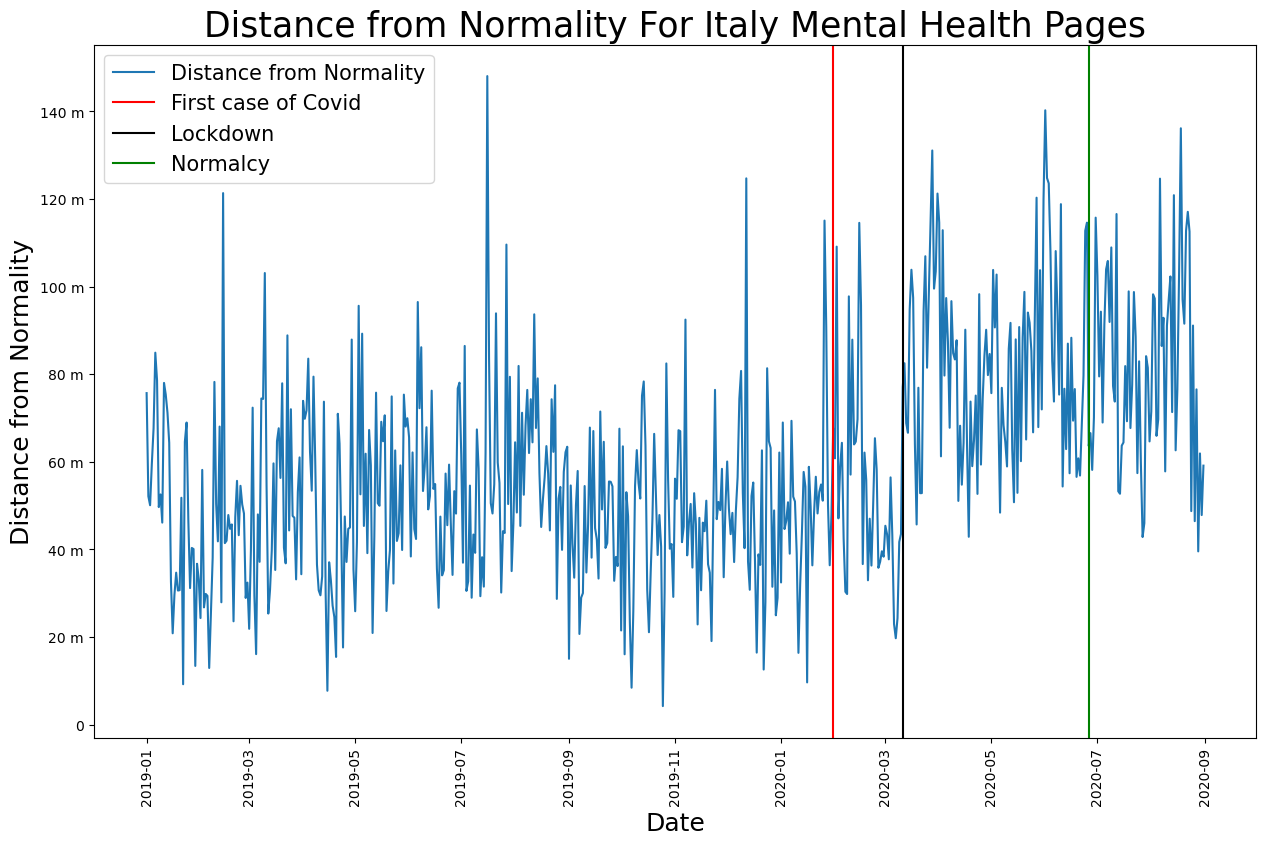

In [15]:
plotDistanceFromNormality('it')

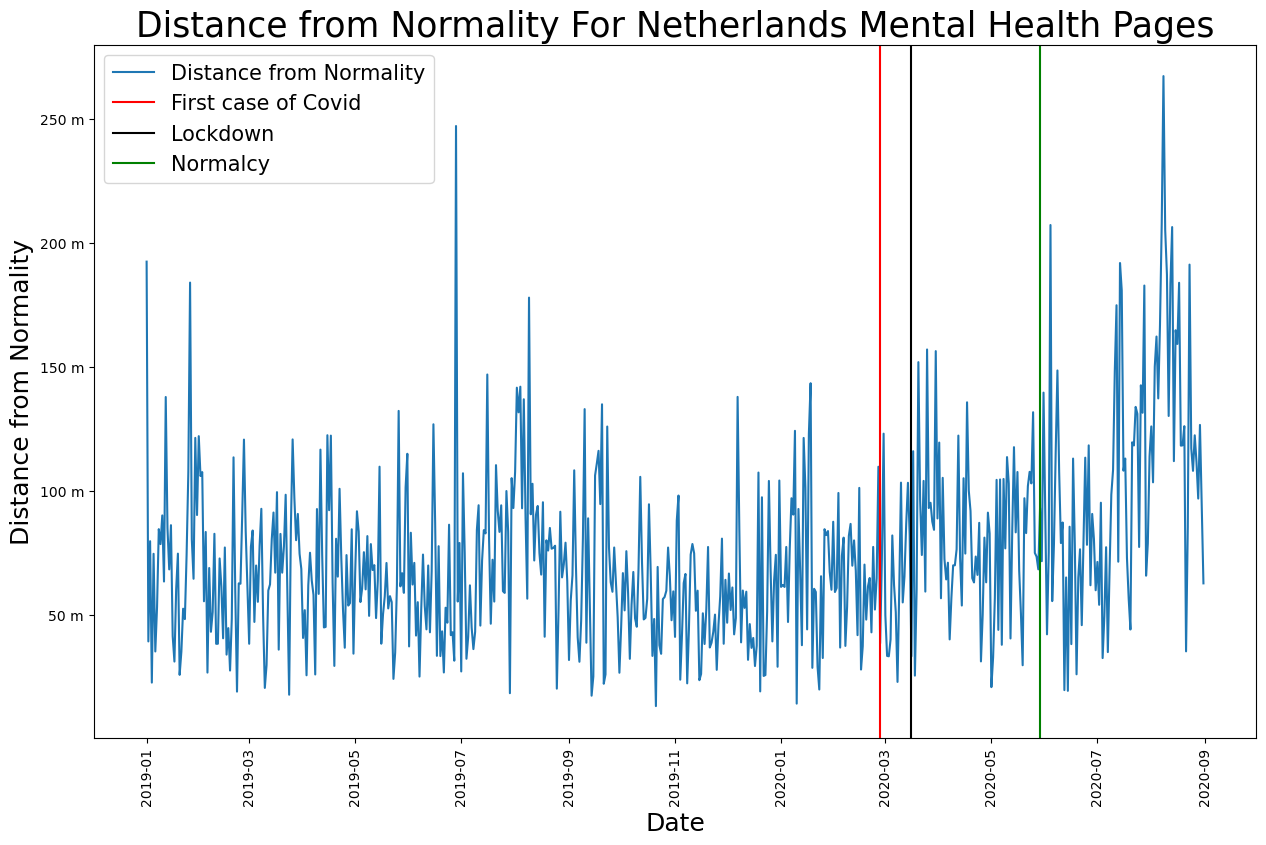

In [16]:
plotDistanceFromNormality('nl')

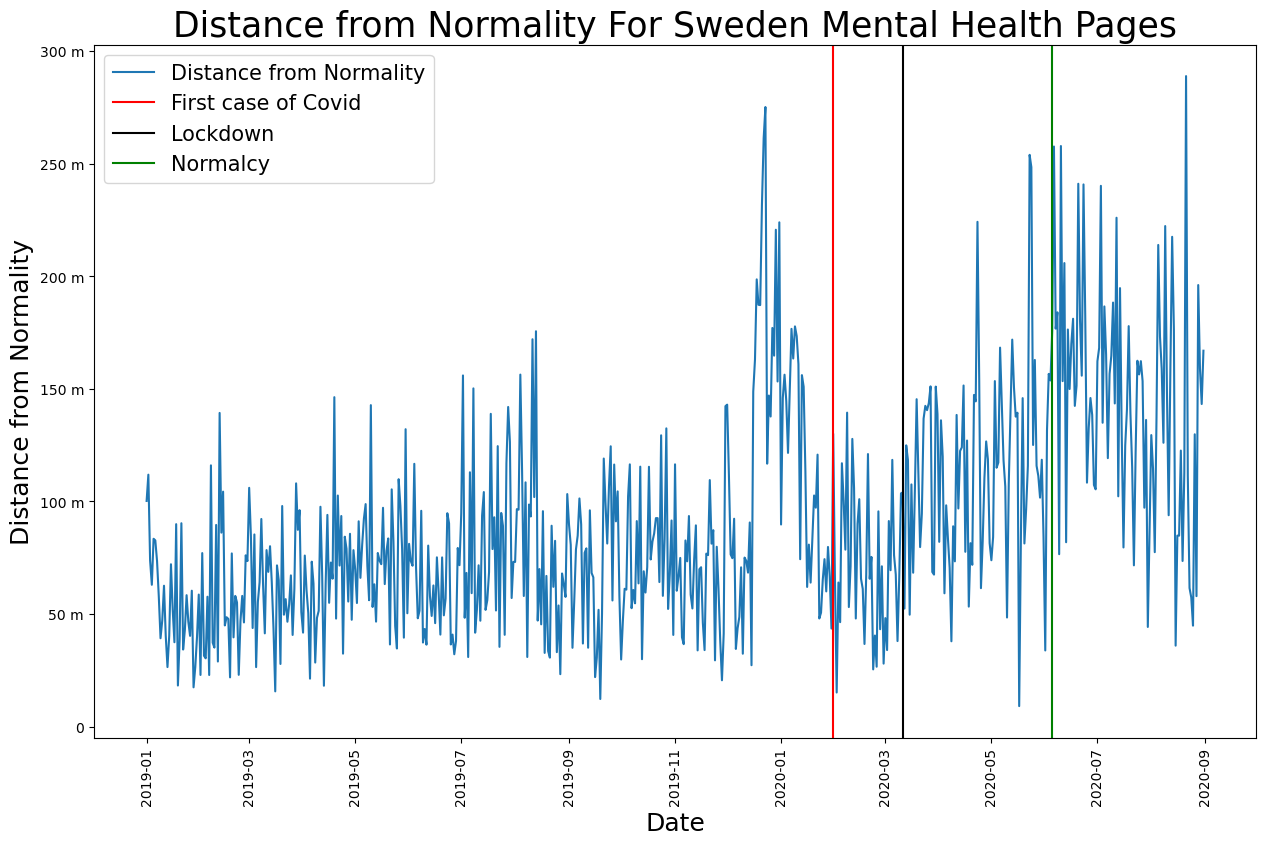

In [17]:
plotDistanceFromNormality('sv')

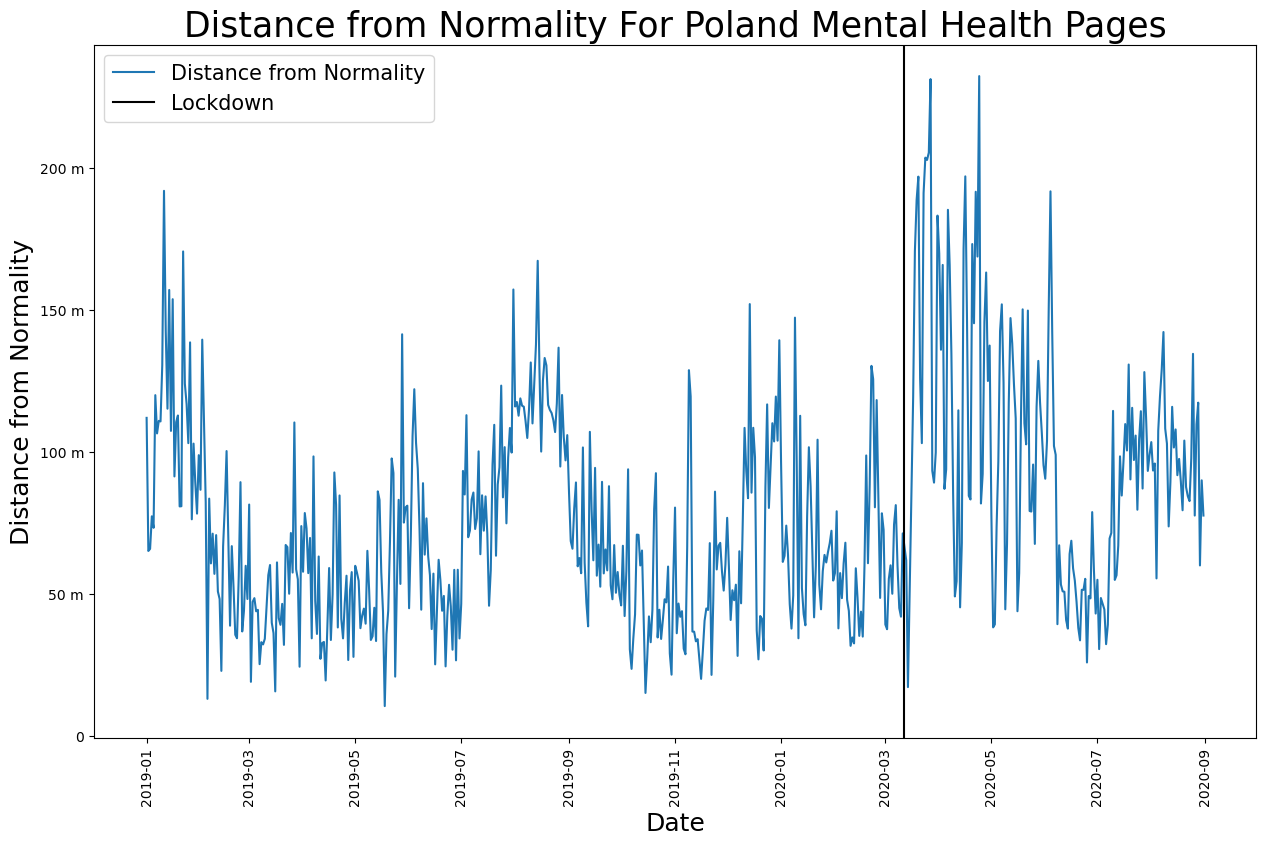

In [18]:
plotDistanceFromNormality('pl')



On the graphs, we see that for Italy and Poland, the distance from the normal attention vector changed significantly during the lockdown. That's why there has been some change in users' attention to mental health topics. There have also been some changes in Sweden, but they started before the lockdown, so the reason for this is not the lockdown. As for the Netherlands, there are no significant changes. These graphs show us the changes in normality for Italy and Poland, but it is unclear in which direction these changes have taken place. Perhaps people have started visiting pages about mental health less. To understand this and go beyond a visual inspection and accurately quantify changes in the volume of pageviews, we will use the "difference in differences" regression approach.

# Difference-in-differences regression.

Difference-in-differences regression is a “quasi-experimental” technique that mimics an experimental design with observational data by studying the effect of a treatment (e.g., lockdown) on a treatment group vs. a control group. The difference-in-differences method aims at separating the true treatment effect from simultaneous (e.g., seasonal) changes that would have occurred even without the treatment. To do so, we calculate the post-minus-pre-treatment difference (in 2020) and compare it to the difference between the corresponding time periods in the previous year (2019). Subtracting the 2019 difference from the 2020 difference (yielding the “difference in differences”) thus removes changes that would have occurred even without the intervention (assuming 2020 would otherwise have looked like 2019) and gives a better estimate of the treatment effect.

We will compare the difference in activity seven weeks before vs. seven weeks after the lockdown. The idea here is to capture what changes were introduced by the sudden halts in human mobility induced by non-phamaceutical interventions.

In this setup, we fix disease and consider, for each language, a time window of 14 weeks (98 days) split around either the lockdown date in 2020, as well as the corresponding time window in 2019. Each of these 196 days contributes one data point per language, for a total of 196 × 4  = 784 data points. As the dependent variable y, we use the logarithm of the number of page views, and as independent variables, the following three factors: year (2019 or 2020), lockdown (before or after the calendar day of lockdown), and language. We now model y as a linear function of these three factors and all their two and three-way interactions. In R formula notation,

y ∼ year * lockdown * language.

Pageview volumes were considered in logarithmic form for two reasons: first, because raw pageview counts are far from normally distributed, with numerous large outliers, and second, because the logarithm makes the model multiplicative, thus implicitly normalizing the estimated effects and making it possible to compare languages with different pageview volumes: if b is the coefficient of the three-way interaction year : lockdown : language, then exp(b) captures the multiplicative factor by which disease pageview volumes in a given language increased when lockdown happened,  after taking into account differences related only to the year or only to lockdown, which are already captured by the coefficients of year : language and lockdown : language, respectively.

In [19]:
# Let's find the lockdown date for each language and the dates 7 weeks before lockdown and 7 weeks after lockdown.
# We also need these dates for 2019.

# dict for storing dates for each language
dates = {}
period_weeks = 7
for lang in LANGUAGES:
    # lockdown date
    start_lockdown_2020 = interventions_data['Lockdown'].loc[lang] 
    if start_lockdown_2020 is pd.NaT:
        start_lockdown_2020 = interventions_data['Mobility'].loc[lang] 
    #7 week before lockdown date
    before_lockdown_2020 = start_lockdown_2020 - relativedelta(weeks=period_weeks)
    #7 week after lockdown date
    after_lockdown_2020 = start_lockdown_2020 + relativedelta(weeks=period_weeks)
    
    # same dates in 2019
    start_lockdown_2019 = start_lockdown_2020 - relativedelta(years=1)
    before_lockdown_2019 = before_lockdown_2020 - relativedelta(years=1)
    after_lockdown_2019 = after_lockdown_2020 - relativedelta(years=1)
    dates[lang] = [before_lockdown_2019, start_lockdown_2019, after_lockdown_2019, before_lockdown_2020, start_lockdown_2020, 
                   after_lockdown_2020]
    
dates

{'nl': [Timestamp('2019-01-27 00:00:00'),
  Timestamp('2019-03-16 00:00:00'),
  Timestamp('2019-05-04 00:00:00'),
  Timestamp('2020-01-27 00:00:00'),
  Timestamp('2020-03-16 00:00:00'),
  Timestamp('2020-05-04 00:00:00')],
 'sv': [Timestamp('2019-01-22 00:00:00'),
  Timestamp('2019-03-11 00:00:00'),
  Timestamp('2019-04-29 00:00:00'),
  Timestamp('2020-01-22 00:00:00'),
  Timestamp('2020-03-11 00:00:00'),
  Timestamp('2020-04-29 00:00:00')],
 'pl': [Timestamp('2019-01-23 00:00:00'),
  Timestamp('2019-03-12 00:00:00'),
  Timestamp('2019-04-30 00:00:00'),
  Timestamp('2020-01-23 00:00:00'),
  Timestamp('2020-03-12 00:00:00'),
  Timestamp('2020-04-30 00:00:00')],
 'it': [Timestamp('2019-01-22 00:00:00'),
  Timestamp('2019-03-11 00:00:00'),
  Timestamp('2019-04-29 00:00:00'),
  Timestamp('2020-01-22 00:00:00'),
  Timestamp('2020-03-11 00:00:00'),
  Timestamp('2020-04-29 00:00:00')]}

In [20]:
# This function checks whether the given date falls within the period under consideration.
def findPeriod(x, lang, dates) -> int:
    if x < dates[lang][0] or (x > dates[lang][2] and x < dates[lang][3]) or x > dates[lang][5]:
        return -1
    if x < dates[lang][1] or (x >= dates[lang][3] and x < dates[lang][4]):
        return 0
    return 1
        

# A function for preparing data for regression.    
def prepareData(dates, disease):
    # new DataFrame for required features.
    new_df = pd.DataFrame({'Year' :[], 'Period':[], 'Language': [], 'PageViews': []})
    for lang in LANGUAGES: 
        # pageviews for a given language
        df = pageviews_data[lang].copy()

        # pageviews for a given language and the required period.
        df['Period'] = df['Date'].apply(lambda x: findPeriod(x, lang, dates))
        df = df[df['Period'] != -1]

        # Take the logarithm of page views
        df['PageViews'] = np.log(df[disease])

        # Add categorical feature language.
        df['Language'] = [lang]*len(df)

        # add to new dataframe
        new_df = pd.concat([new_df, df[new_df.columns]])
    return new_df
            
# A function for findinf sem
def get_standard_error_sum(results, covariates):
    '''
    #95CI is approximated with +- 2 sum_variance_standard_error
    '''
    # get the variance covariance matrix
    vcov = results.cov_params() \
        .loc[covariates, covariates].values

    # calculate the sum of all pair wise covariances by summing up off-diagonal entries
    off_dia_sum = np.sum(vcov)
    # variance of a sum of variables is the square root
    return np.sqrt(off_dia_sum)
    
# A function for determining the expected logarithmic effect of lockdown on the number of page views of the given disease.
def get_diffs_in_diffs_result(dates, disease):
    df = prepareData(dates, disease)
    # Regression formula    
    np.random.seed(2)
    res = smf.ols(formula='PageViews ~  C(Year) * C(Period) * C(Language)', data=df).fit()
    res = res.get_robustcov_results(cov_type='HC0')
    res = statsmodels.regression.linear_model.RegressionResultsWrapper(res)
    
    # Print summary
    print('\n Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) \n')
    print(res.summary())
    

    df_list = []
    
    # For each language find the estimated logarithmic effects of lockdown on volume of page views of the given disease.
    for lang in LANGUAGES:
        if lang == 'it':
            val = res.params['C(Year)[T.2020]:C(Period)[T.1.0]']
            std = get_standard_error_sum(res, ['C(Year)[T.2020]:C(Period)[T.1.0]'])
        else:                                
            val = res.params['C(Year)[T.2020]:C(Period)[T.1.0]'] + \
                  res.params['C(Year)[T.2020]:C(Period)[T.1.0]:C(Language)[T.{}]'.format(lang)] 
                 

            std = get_standard_error_sum(res, ['C(Year)[T.2020]:C(Period)[T.1.0]',
                                               'C(Year)[T.2020]:C(Period)[T.1.0]:C(Language)[T.{}]'.format(lang)])
    

        tmp_dict = {
            "lang": lang, # language
            "low": val - 2 * std, # begin of CI
            "high": val + 2 * std, # end of CI
            "val": val, # the value of effect
            "pval": (val - 2 * std > 0) or (val + 2 * std < 0), # Is the effect significant?
            "std": std
        }

        df_list.append(tmp_dict)

    return pd.DataFrame(df_list)

# Function for plotting the effect for each country
def plot_diffs_in_diffs_all(dates, disease):
    df_results = get_diffs_in_diffs_result(dates, disease)
    df_results = df_results.reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(14, 8), sharex="col",
                       gridspec_kw={"hspace": 0.075, "wspace": 0.05, "top": 0.9, "bottom":0.15})

    idx = 0
    labels = []
    for lang in LANGUAGES:
        
        row = df_results[(df_results.lang == lang)].iloc[0]
        row = dict(row)
        if row["pval"]: 
            print('\n\nRelative Increase (log) in {}: {}'.format(region[lang], row['val']))
        # desktop ci
        ax.plot([row["low"], row["high"]], [idx, idx], color="#e41a1c", zorder=1)

        # desktop mean
        marker = "." if row["pval"] else "x"
        ax.scatter([row["val"]], [idx], color="black", marker=marker, zorder=2)


        ax.axhline(idx + 0.5, lw=0.5, ls=":", color='black', alpha=0.5)

        idx += 1
        labels.append(region[row["lang"]])

        _ = ax.set_yticks(range(0, idx))
        _ = ax.set_yticklabels(labels, fontsize=20)

        ax.set_ylim([-0.5, 11.5])
        
    ax.axvline(0, zorder=0, color="black", ls="-", alpha=0.3)

    ax.set_xlim([-0.6, 0.6])
    ax.set_xticks([-0.6, -0.3, 0, 0.3, 0.6])
    ax.yaxis.tick_right()
    ax.set_title('Relative Increase ($\log_e$) in page views for a Wikipedia article "{}" during lockdown'.format(disease), size=25)
    ax.set_xlabel("Relative Increase ($\log_e$)", size=20)
    lines = [
        Line2D([0], [0], color="black", lw=0, marker="x"),

    ]

    ax.legend(
        handles=lines,
        labels=["NOT SIGNIFICANT: p $>$ 0.05"],
        loc='center',
        fancybox=True, shadow=False,
        frameon=False, edgecolor=None, fontsize=12,
        borderaxespad=0
    )
    plt.show()



 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1122.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:23:55   Log-Likelihood:                 66.971
No. Observations:                 788   AIC:                            -101.9
Df Residuals:                     772   BIC:                            -27.23
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

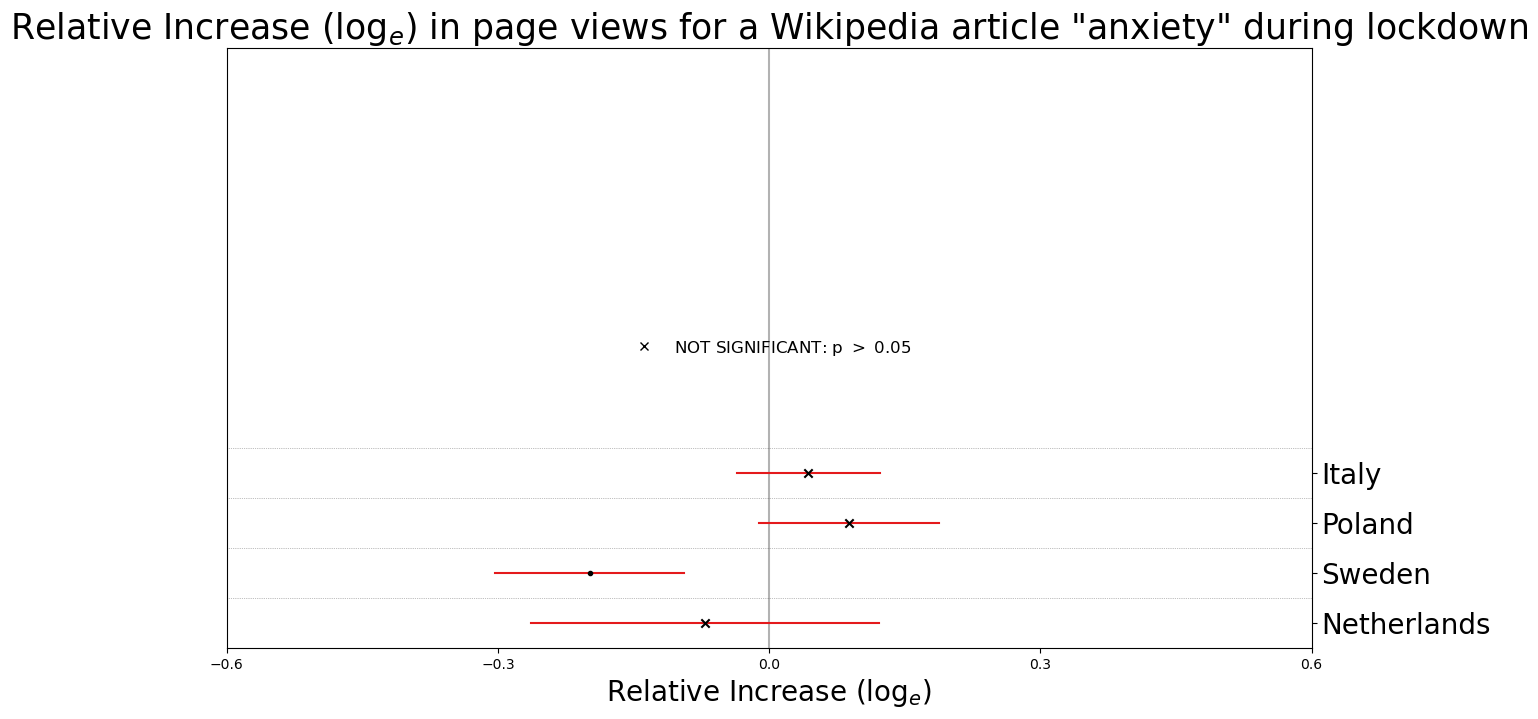

In [21]:
plot_diffs_in_diffs_all(dates, 'anxiety')

The estimated logarithmic effects of lockdown on the volume of pageviews is plotted for **anxiety** by countries. We can see that the logarithmic pre-vs.-post lockdown effect on the Sweden version is around -0.2 (corresponding to a decrease in pageviews to exp(-0.2) ≈ 81%). For other countries, we see insignificant effects. This is quite expected, since during the lockdown people did not go to work, school, or university, but stayed at home, so there were few reasons for anxiety, accordingly, less or equal interest in an article about anxiety. Let's see the plot of pageviews of the article 'anxiety' in the Swedish language in order to observe the effect visually.

In [22]:
#A function for plotting the average number of pageviews by month for all disorders and for a given period
# [start_date, end_date]



def plotDisorderPageViews(lang, disease, start_date, end_date, errorbar='sd'):
    # consider data for the given language
    df = pageviews_data[lang].copy()
    # consider only data in period [start_date, end_date]
    data = df[(df['Date'].dt.date >= start_date.date())  &  
              (df['Date'].dt.date <= end_date.date())]
    
    fig, ax = plt.subplots(figsize=(20, 12))
    plt.title('The monthly average number of page views for a Wikipedia article "{}" from {} to {} in {}'.format(disease, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), region[lang]), fontsize=30)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    # plot horizontal lines for the dates of '1st case', lockdown and Normalcy dates.
    sns.lineplot(data = data, x = "Date", y = disease, label = disease, errorbar=errorbar)
    try:
        plt.axvline(interventions_data.loc[lang]['1st case'], color = 'red', label = 'First case of Covid')
    except:
        pass
    try:
        plt.axvline(interventions_data.loc[lang]['Lockdown'], color = 'black', label = 'Lockdown')
    except:
        plt.axvline(interventions_data.loc[lang]['Mobility'], color = 'black', label = 'Lockdown')
    try:
        plt.axvline(interventions_data.loc[lang]['Normalcy'], color = 'green', label = 'Normalcy')
    except:
        pass
    # Put the date on the x axis vertically 
    ax.tick_params(axis='x', labelrotation=90)
    plt.xlabel('Month', fontsize=20)
    plt.ylabel('PageViews', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

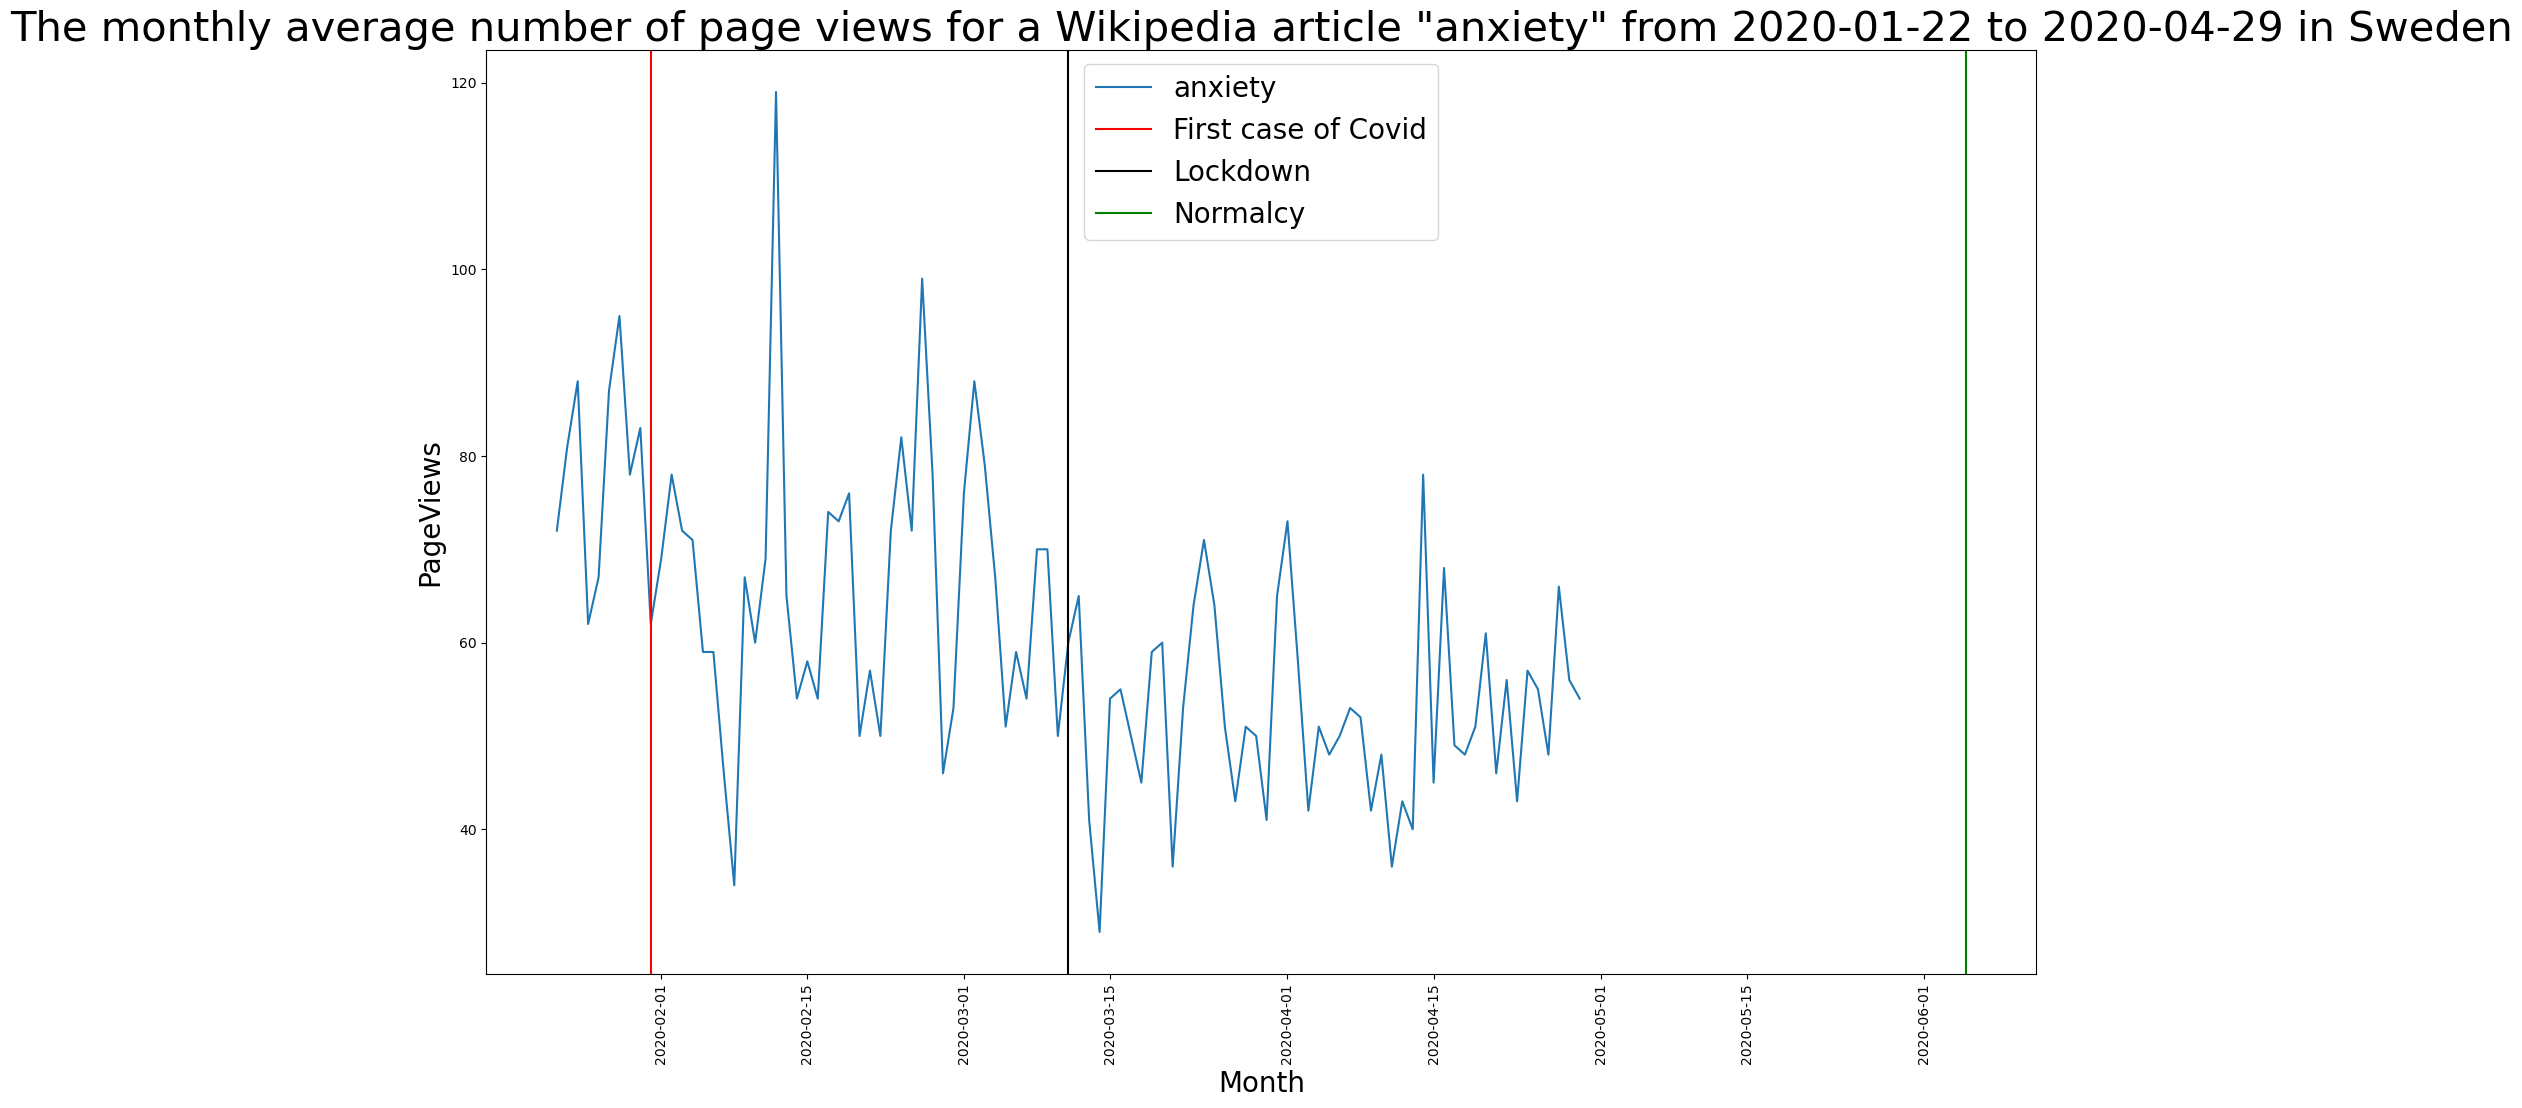

In [23]:
plotDisorderPageViews('sv', 'anxiety', dates['sv'][3], dates['sv'][5])

In the plot above we can see that really during the lockdown the volume of pageviews for the article 'anxiety' in Sweden language decreased. Let's see what happened with other disorders.


 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     974.3
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:23:56   Log-Likelihood:                 294.86
No. Observations:                 788   AIC:                            -557.7
Df Residuals:                     772   BIC:                            -483.0
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

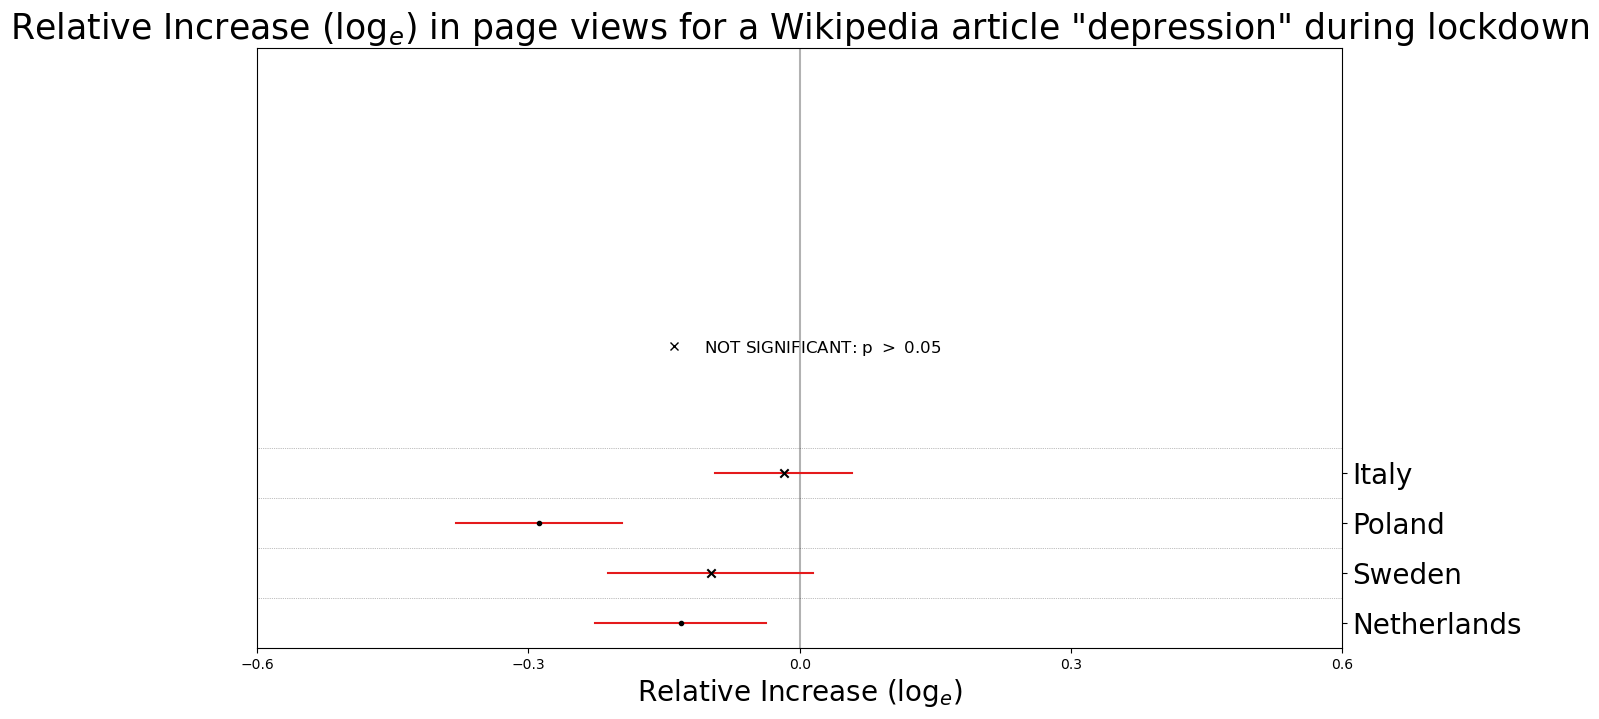

In [24]:
plot_diffs_in_diffs_all(dates, 'depression')

The estimated logarithmic effects of lockdown on the volume of pageviews is plotted for **depression** by countries. Here we can see that the logarithmic pre-vs.-post lockdown effect on the Netherlands version is around -0.13 (corresponding to a decrease in pageviews to exp(-0.123) ≈ 87%) and on the Poland version is around -0.13 (corresponding to a decrease in pageviews to exp(-0.29) ≈ 74%). For other countries, we see insignificant effects. It's a little strange that the number of page views about depression has not increased, and in some countries, it has even decreased on the contrary. Let's see the plot of pageviews of the article **depression** in Dutch and Polish languages in order to observe the effects visually.

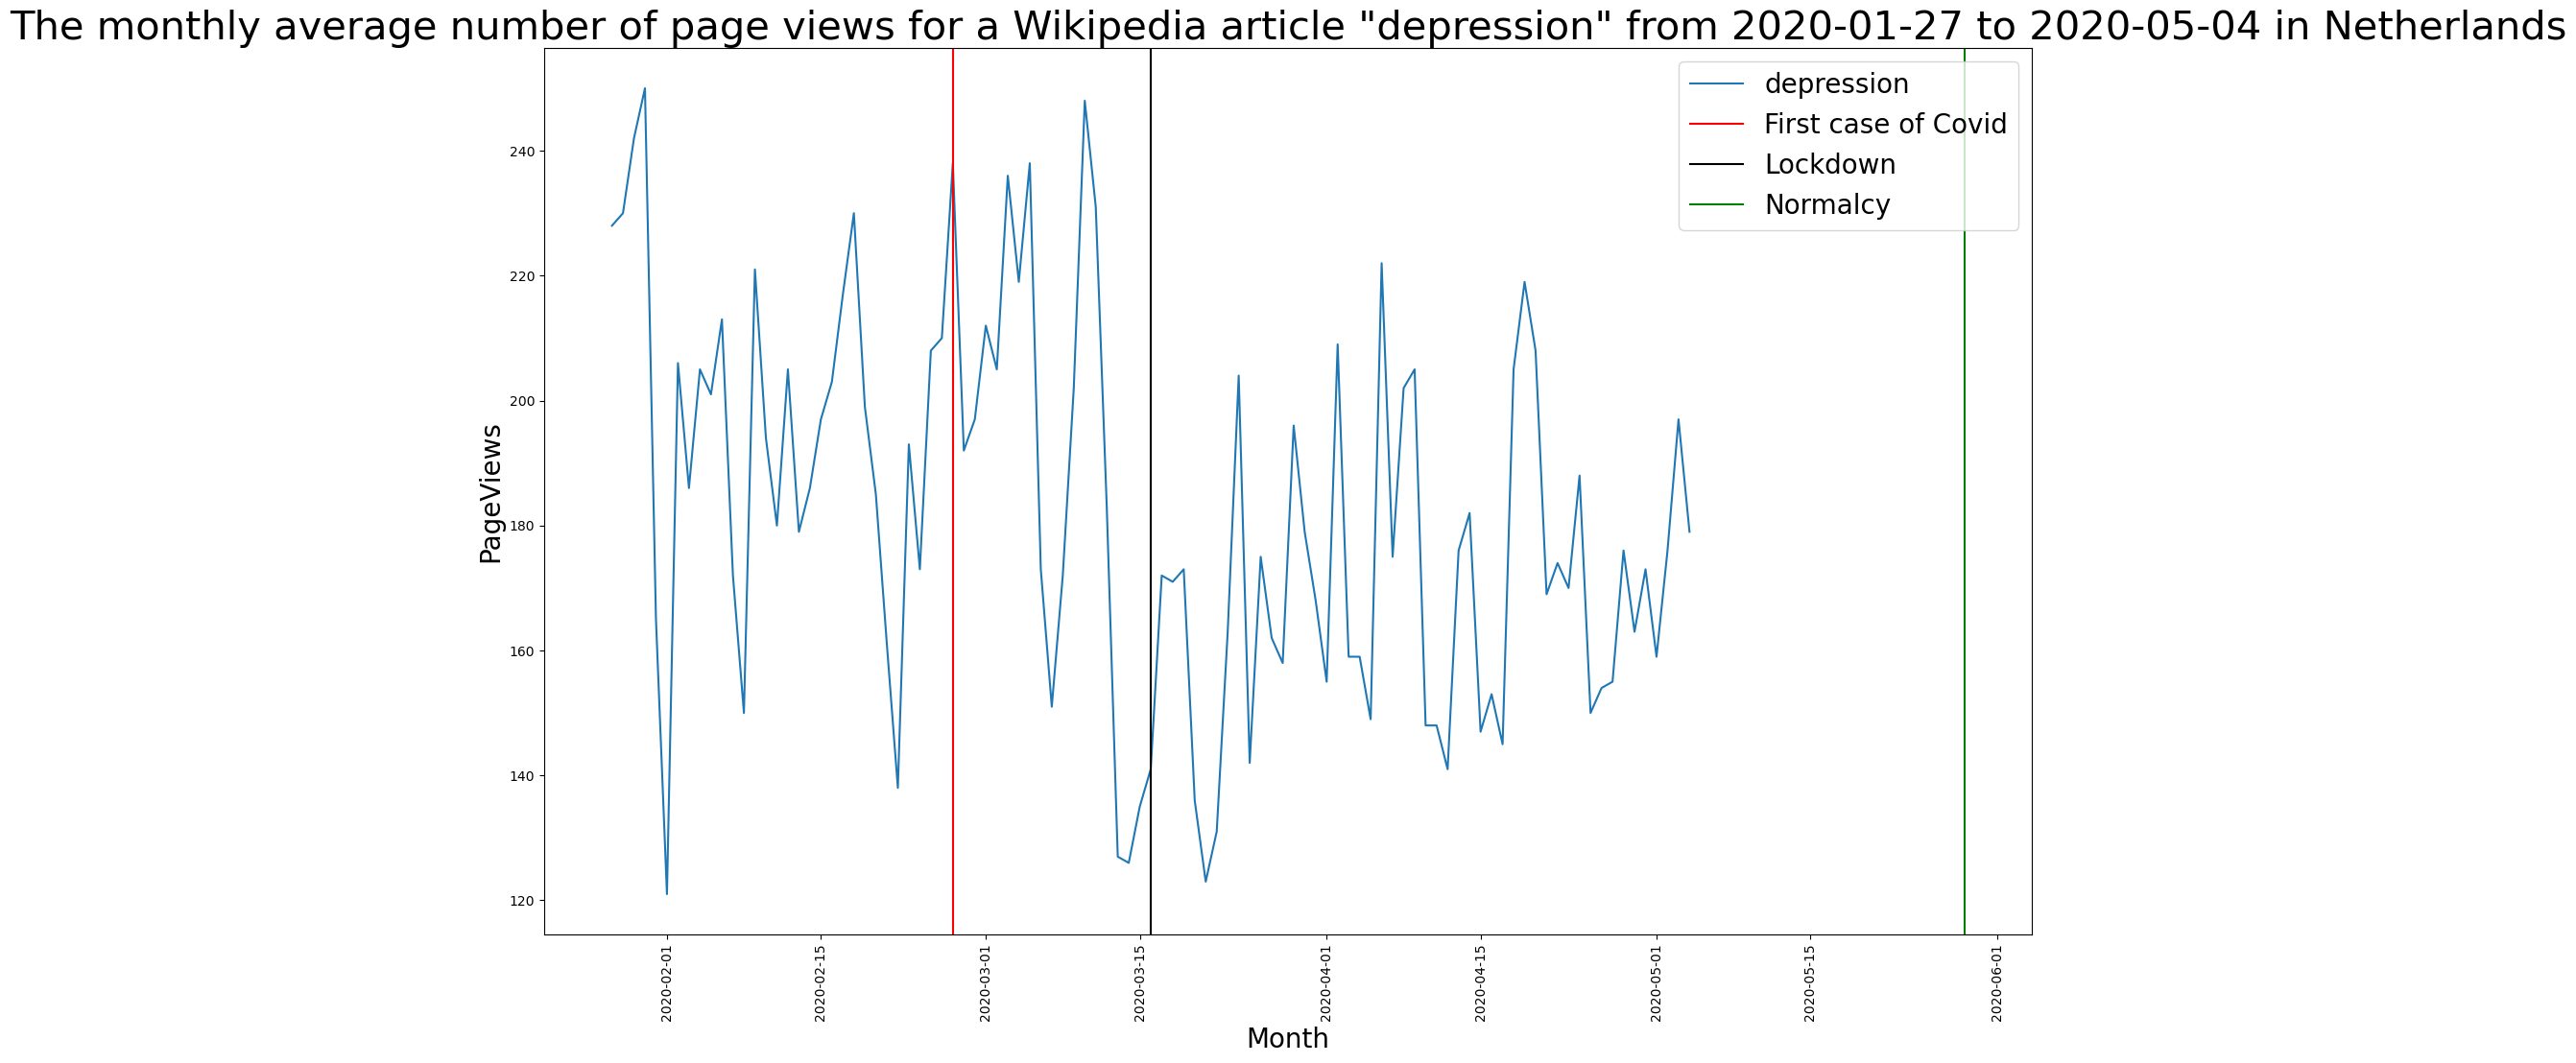

In [25]:
plotDisorderPageViews('nl', 'depression', dates['nl'][3], dates['nl'][5])

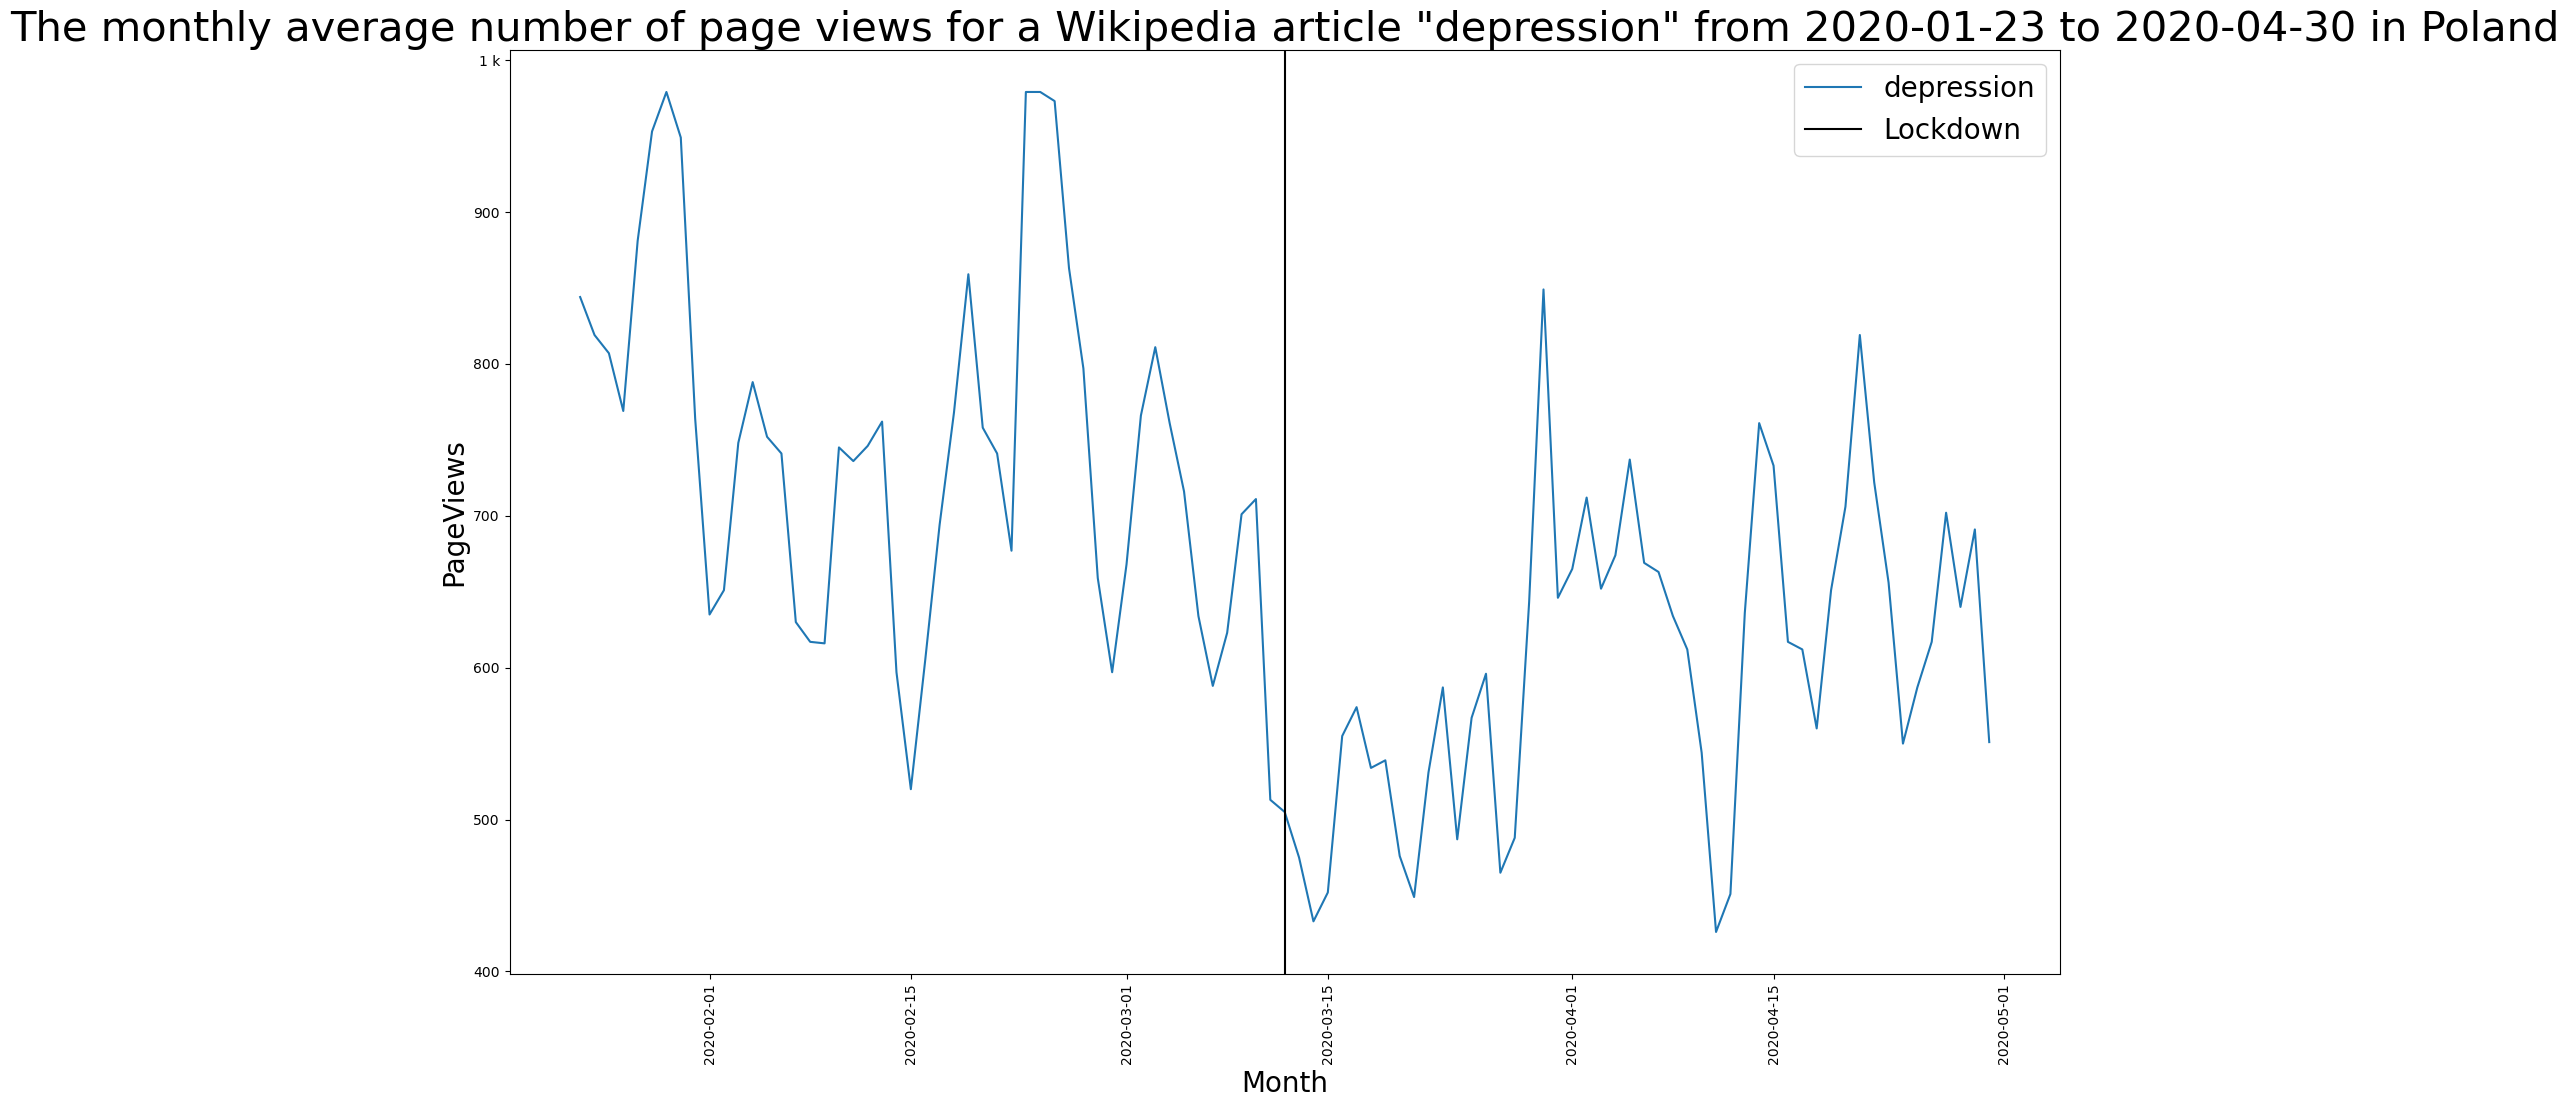

In [26]:
plotDisorderPageViews('pl', 'depression', dates['pl'][3], dates['pl'][5])

Here also the effect is seen visually.


 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     389.9
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:23:57   Log-Likelihood:                 45.793
No. Observations:                 788   AIC:                            -59.59
Df Residuals:                     772   BIC:                             15.13
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

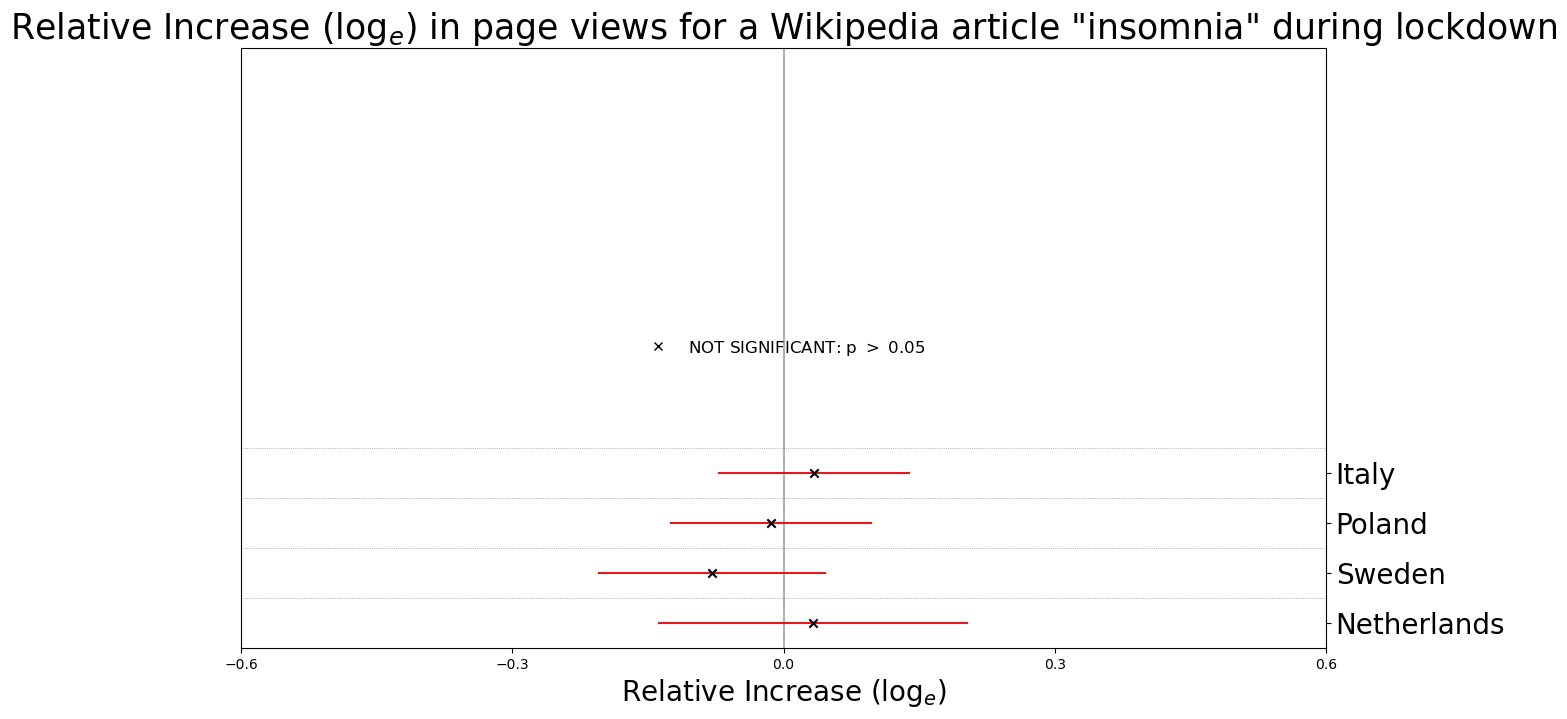

In [27]:
plot_diffs_in_diffs_all(dates, 'insomnia')

For this disorder, we can't say anything because all our results are insignificant.


 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     470.6
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:23:58   Log-Likelihood:                -189.89
No. Observations:                 788   AIC:                             411.8
Df Residuals:                     772   BIC:                             486.5
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

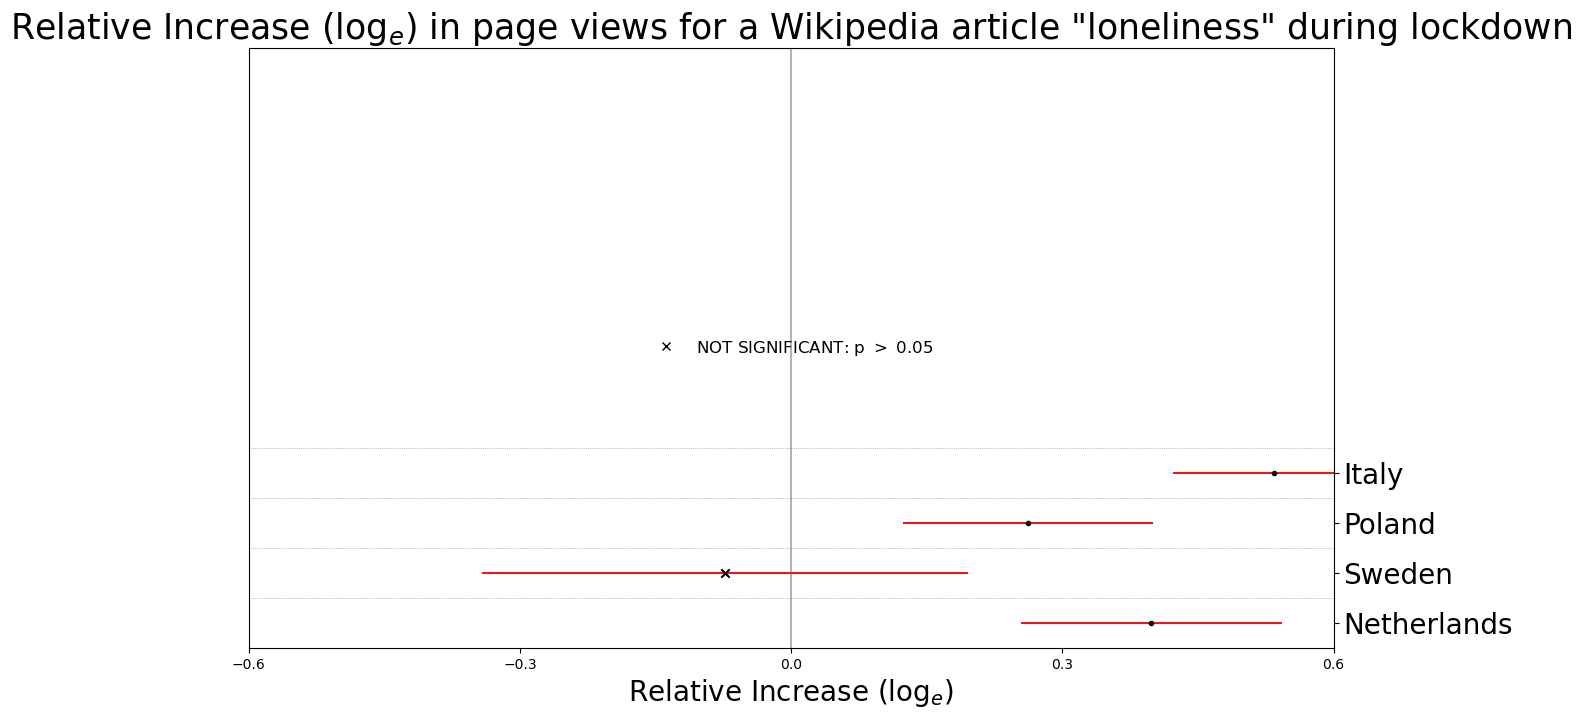

In [28]:
plot_diffs_in_diffs_all(dates, 'loneliness')

Here we can see that the logarithmic pre-vs.-post lockdown effect on the Netherlands version is around 0.4 (corresponding to a increase in pageviews to exp(0.4) ≈ 149%), and on the Poland version is around 0.26 (corresponding to a increase in pageviews to exp(0.26) ≈ 129%) and on the Italy version is around 0.53 (corresponding to a increase in pageviews to exp(0.53) ≈ 169%). For Sweden the effect is insignificant. This increase in page views can be explained by the fact that during the quarantine, a significant number of people stayed at home alone, and since the quarantine lasted for a long time, they began to feel lonely. Let's see the plot of pageviews of the article **loneliness** in Dutch, Polish, and Italian languages to observe the effects visually.

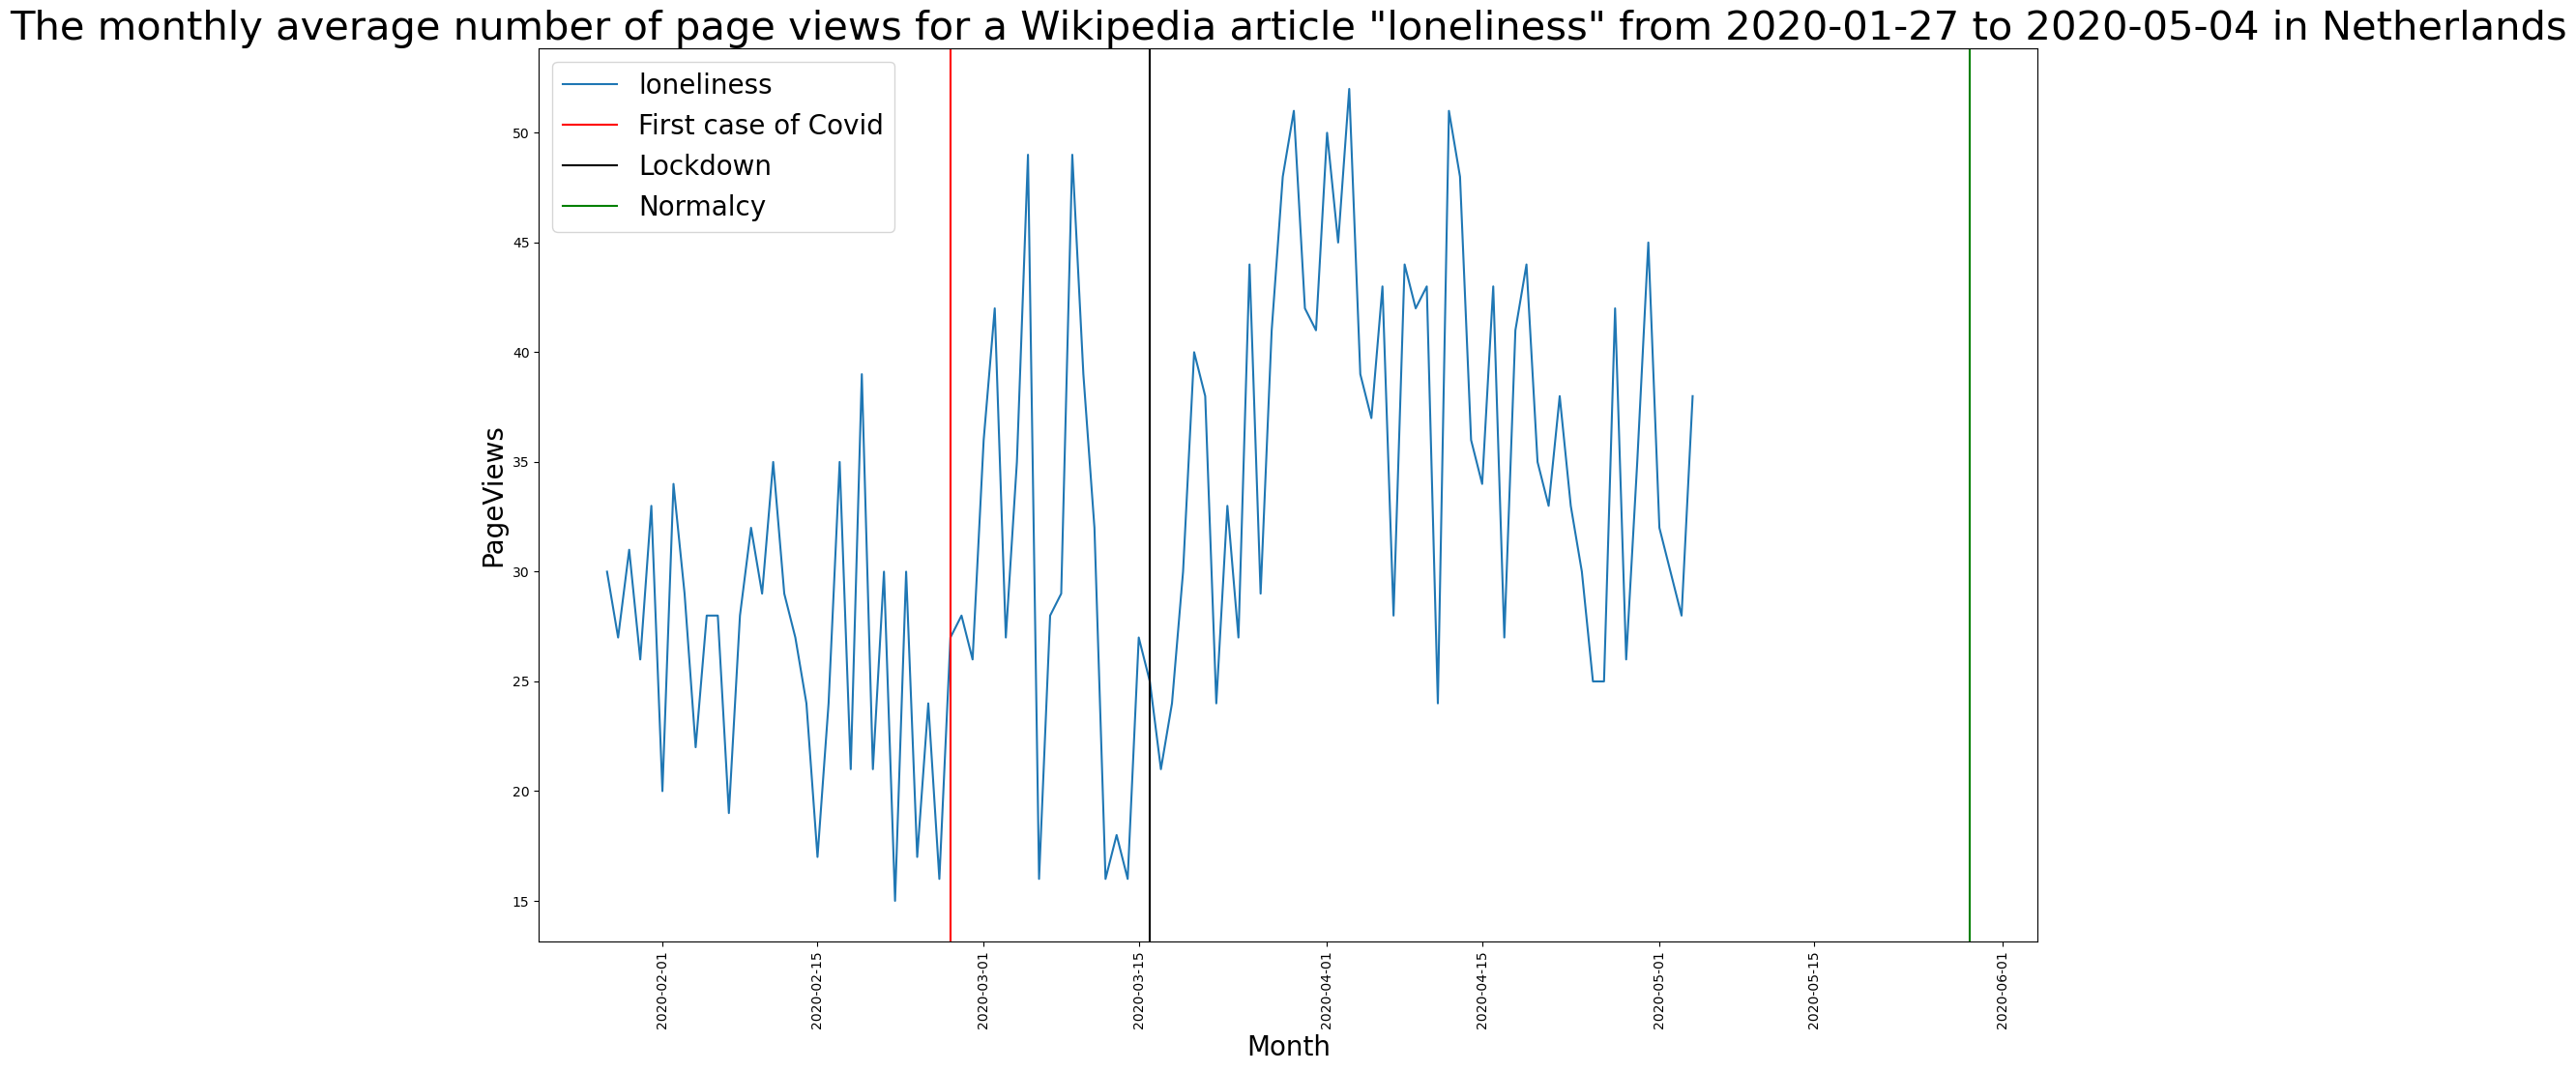

In [29]:
plotDisorderPageViews('nl', 'loneliness', dates['nl'][3], dates['nl'][5])

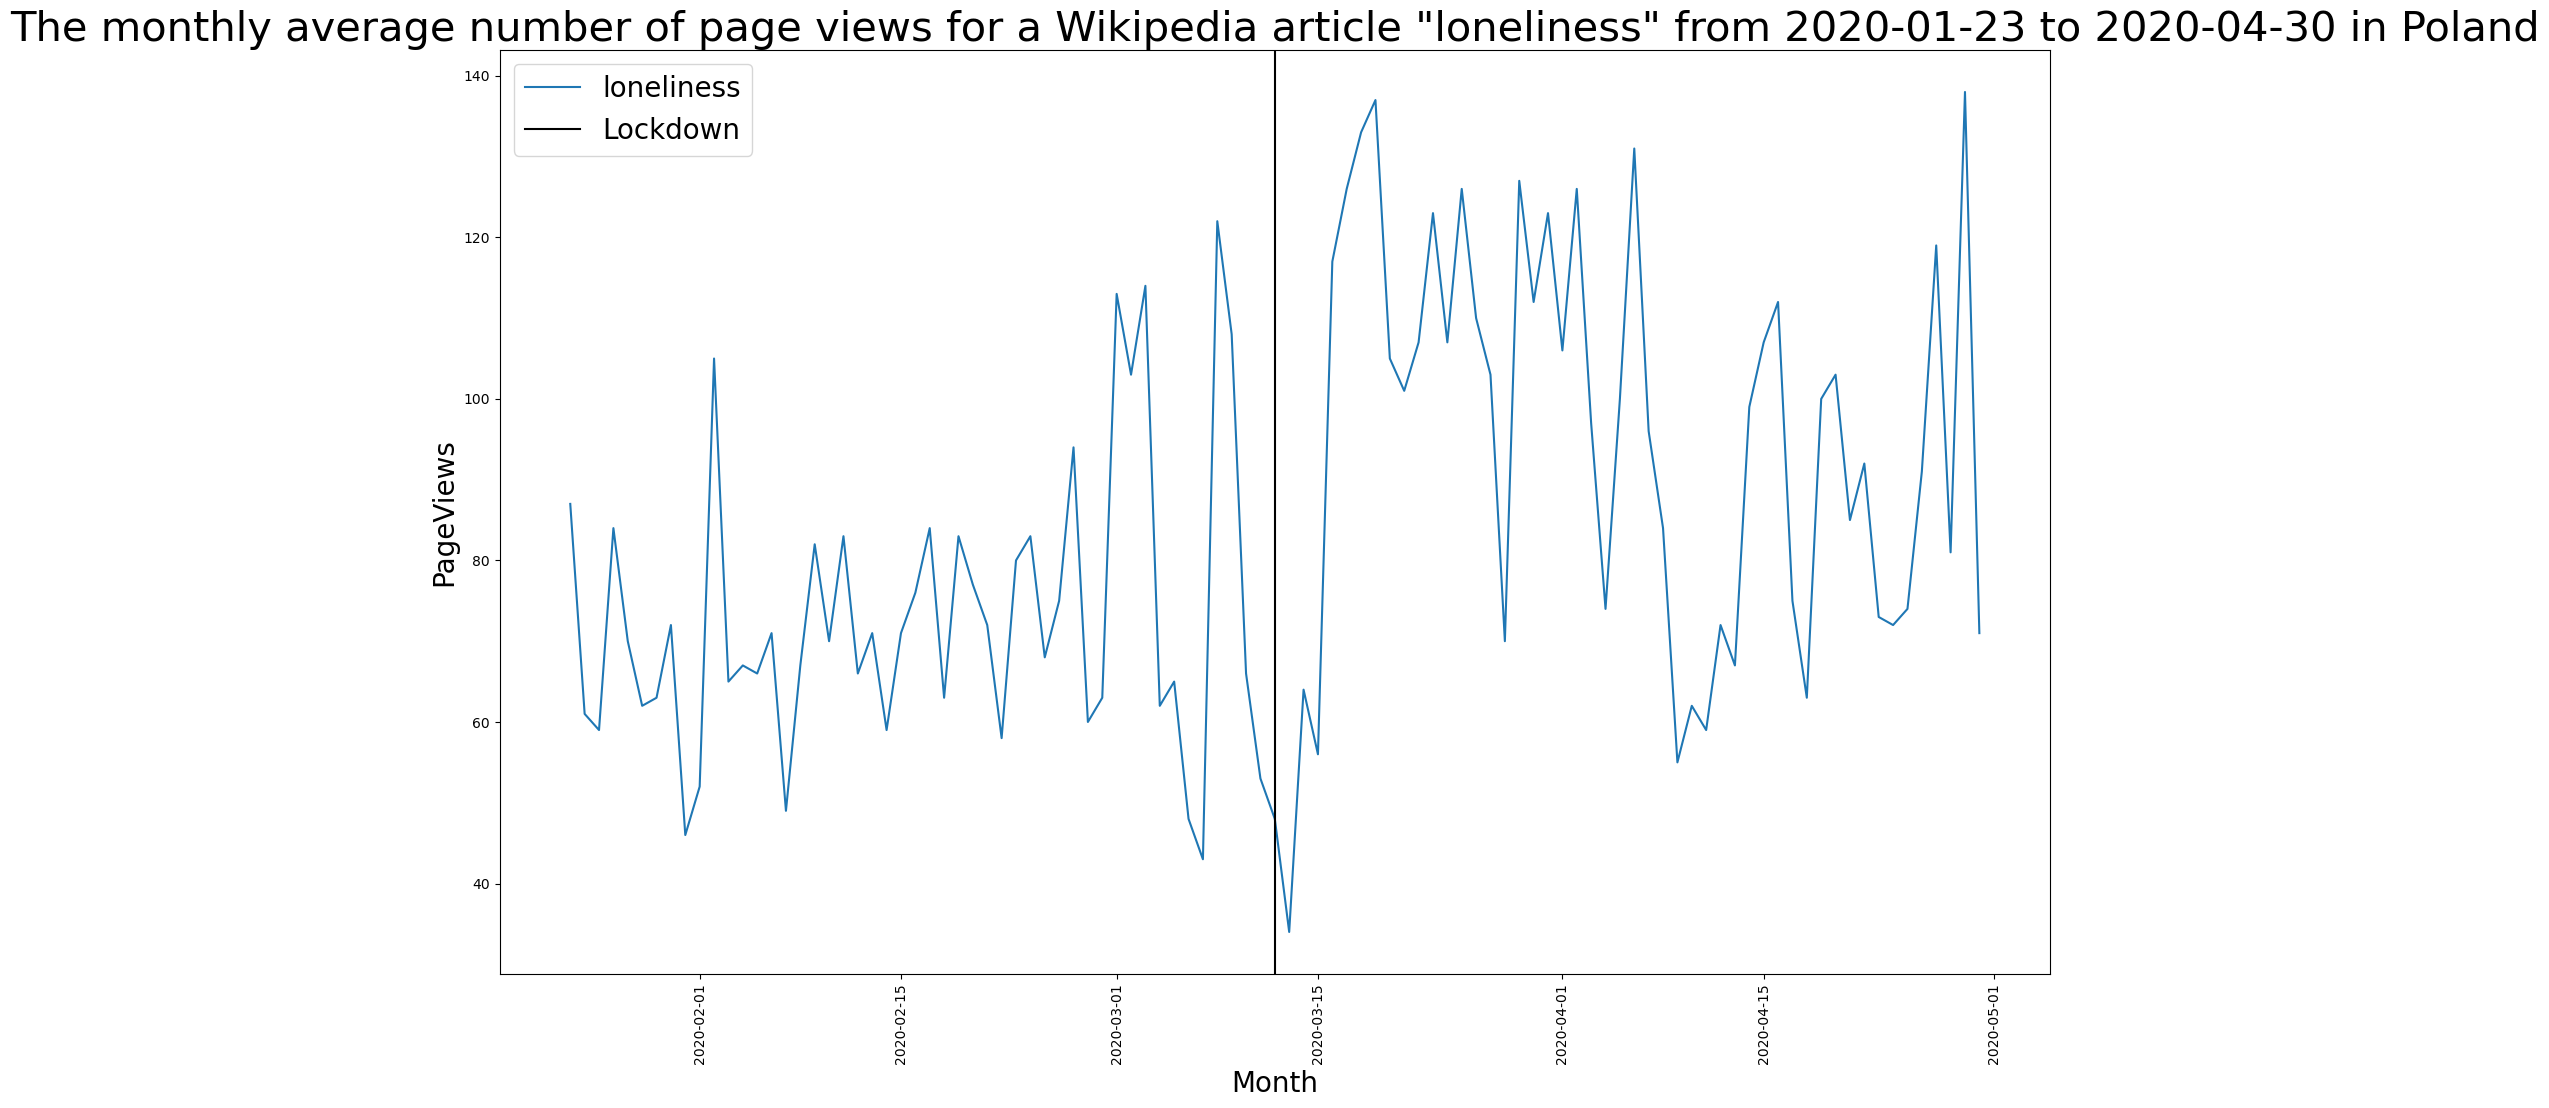

In [30]:
plotDisorderPageViews('pl', 'loneliness', dates['pl'][3], dates['pl'][5])

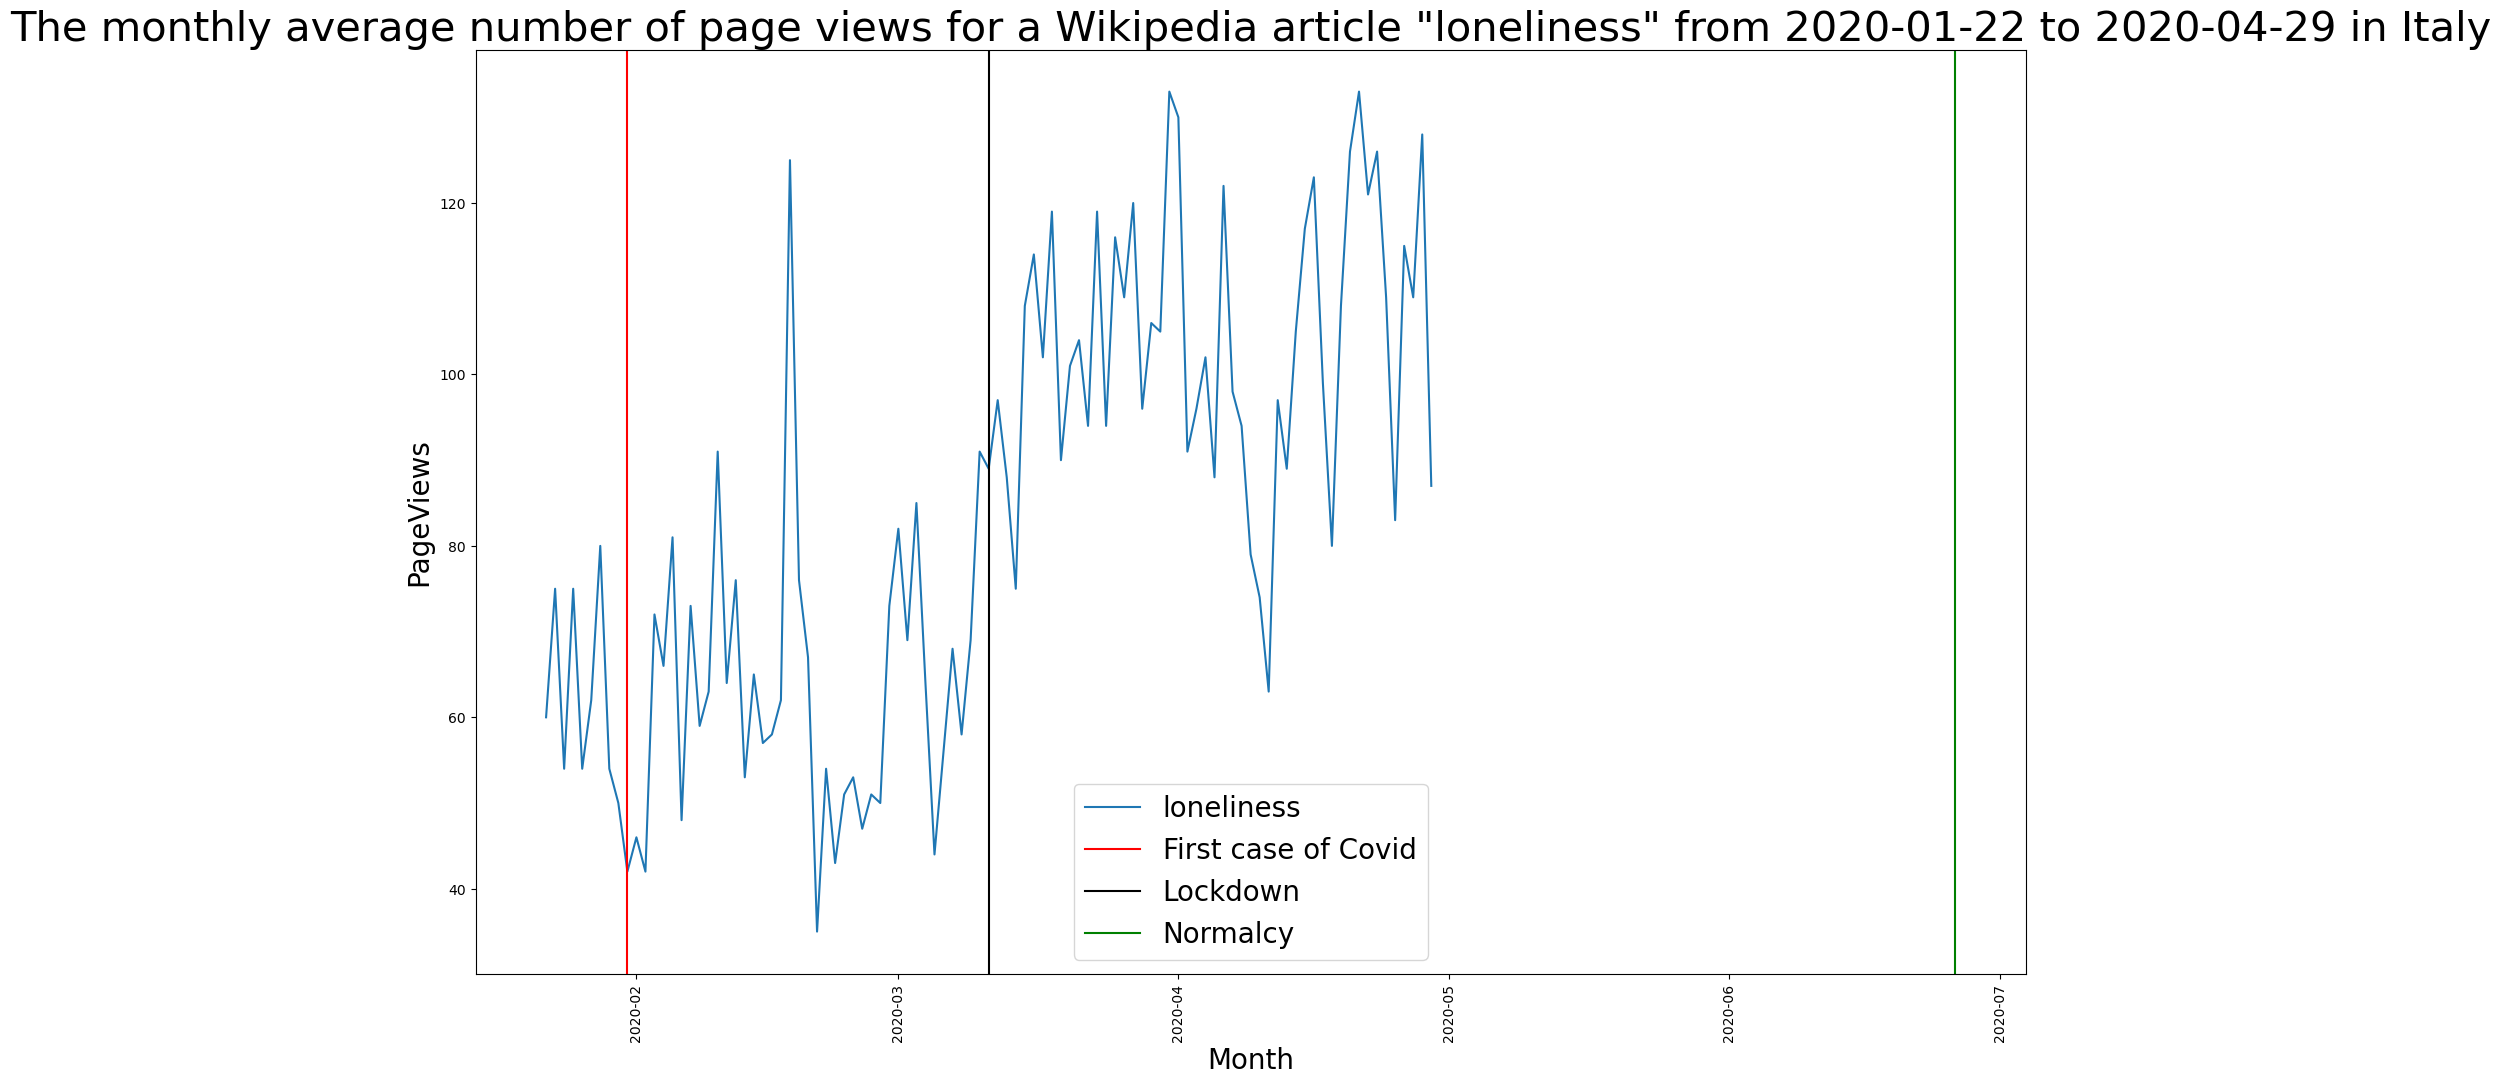

In [31]:
plotDisorderPageViews('it', 'loneliness', dates['it'][3], dates['it'][5])

Here also the effect is seen visually. Let's see for the final disorder 'stress'.


 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     209.0
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          1.25e-259
Time:                        11:23:59   Log-Likelihood:                -98.285
No. Observations:                 788   AIC:                             228.6
Df Residuals:                     772   BIC:                             303.3
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

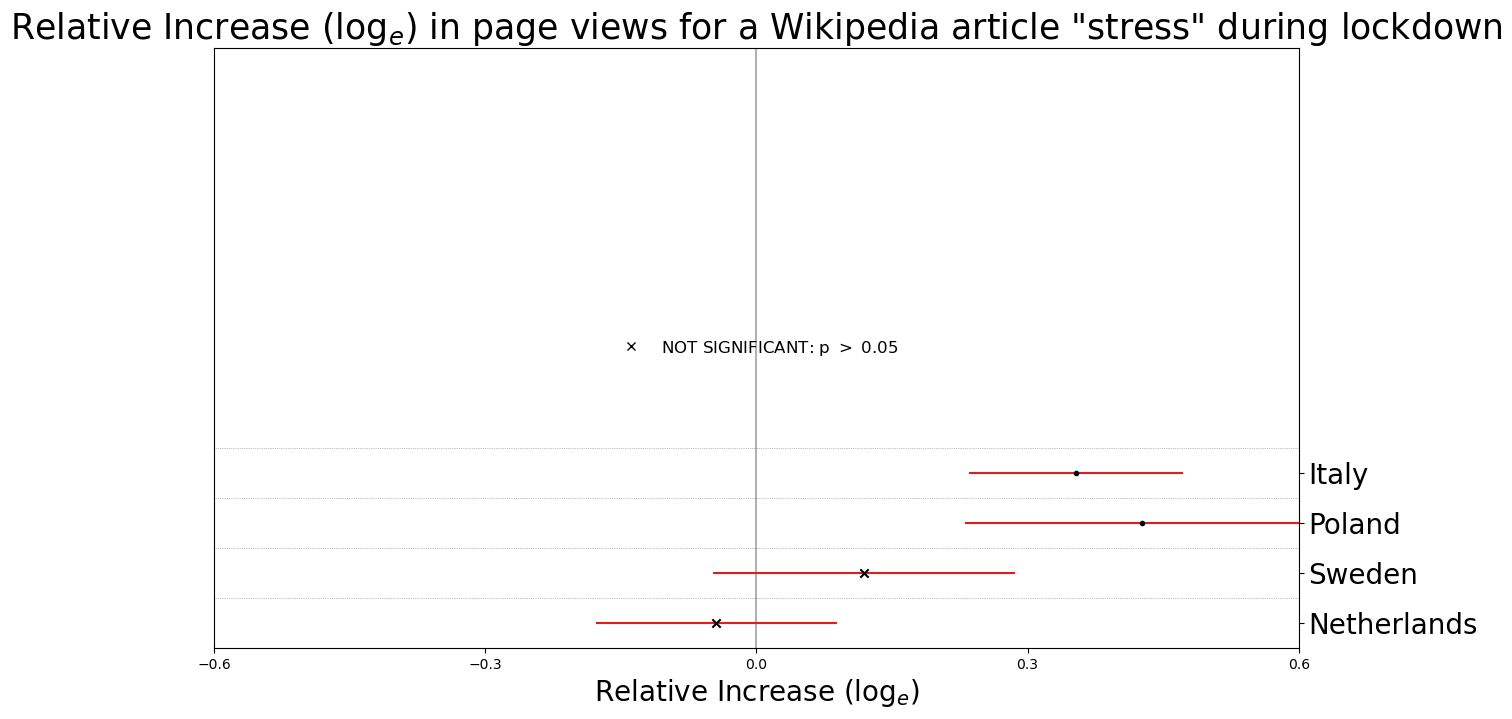

In [32]:
plot_diffs_in_diffs_all(dates, 'stress')

Here we can see that the logarithmic pre-vs.-post lockdown effect on the Polish version is around 0.42 (corresponding to a increase in pageviews to exp(0.42) ≈ 152%) and on the Italian version is around 0.35 (corresponding to a increase in pageviews to exp(0.35) ≈ 141%). For Sweden and Netherlands, the effect is insignificant. Let's see the plot of pageviews of the article **stress** in Polish and Italian languages to observe the effects visually.

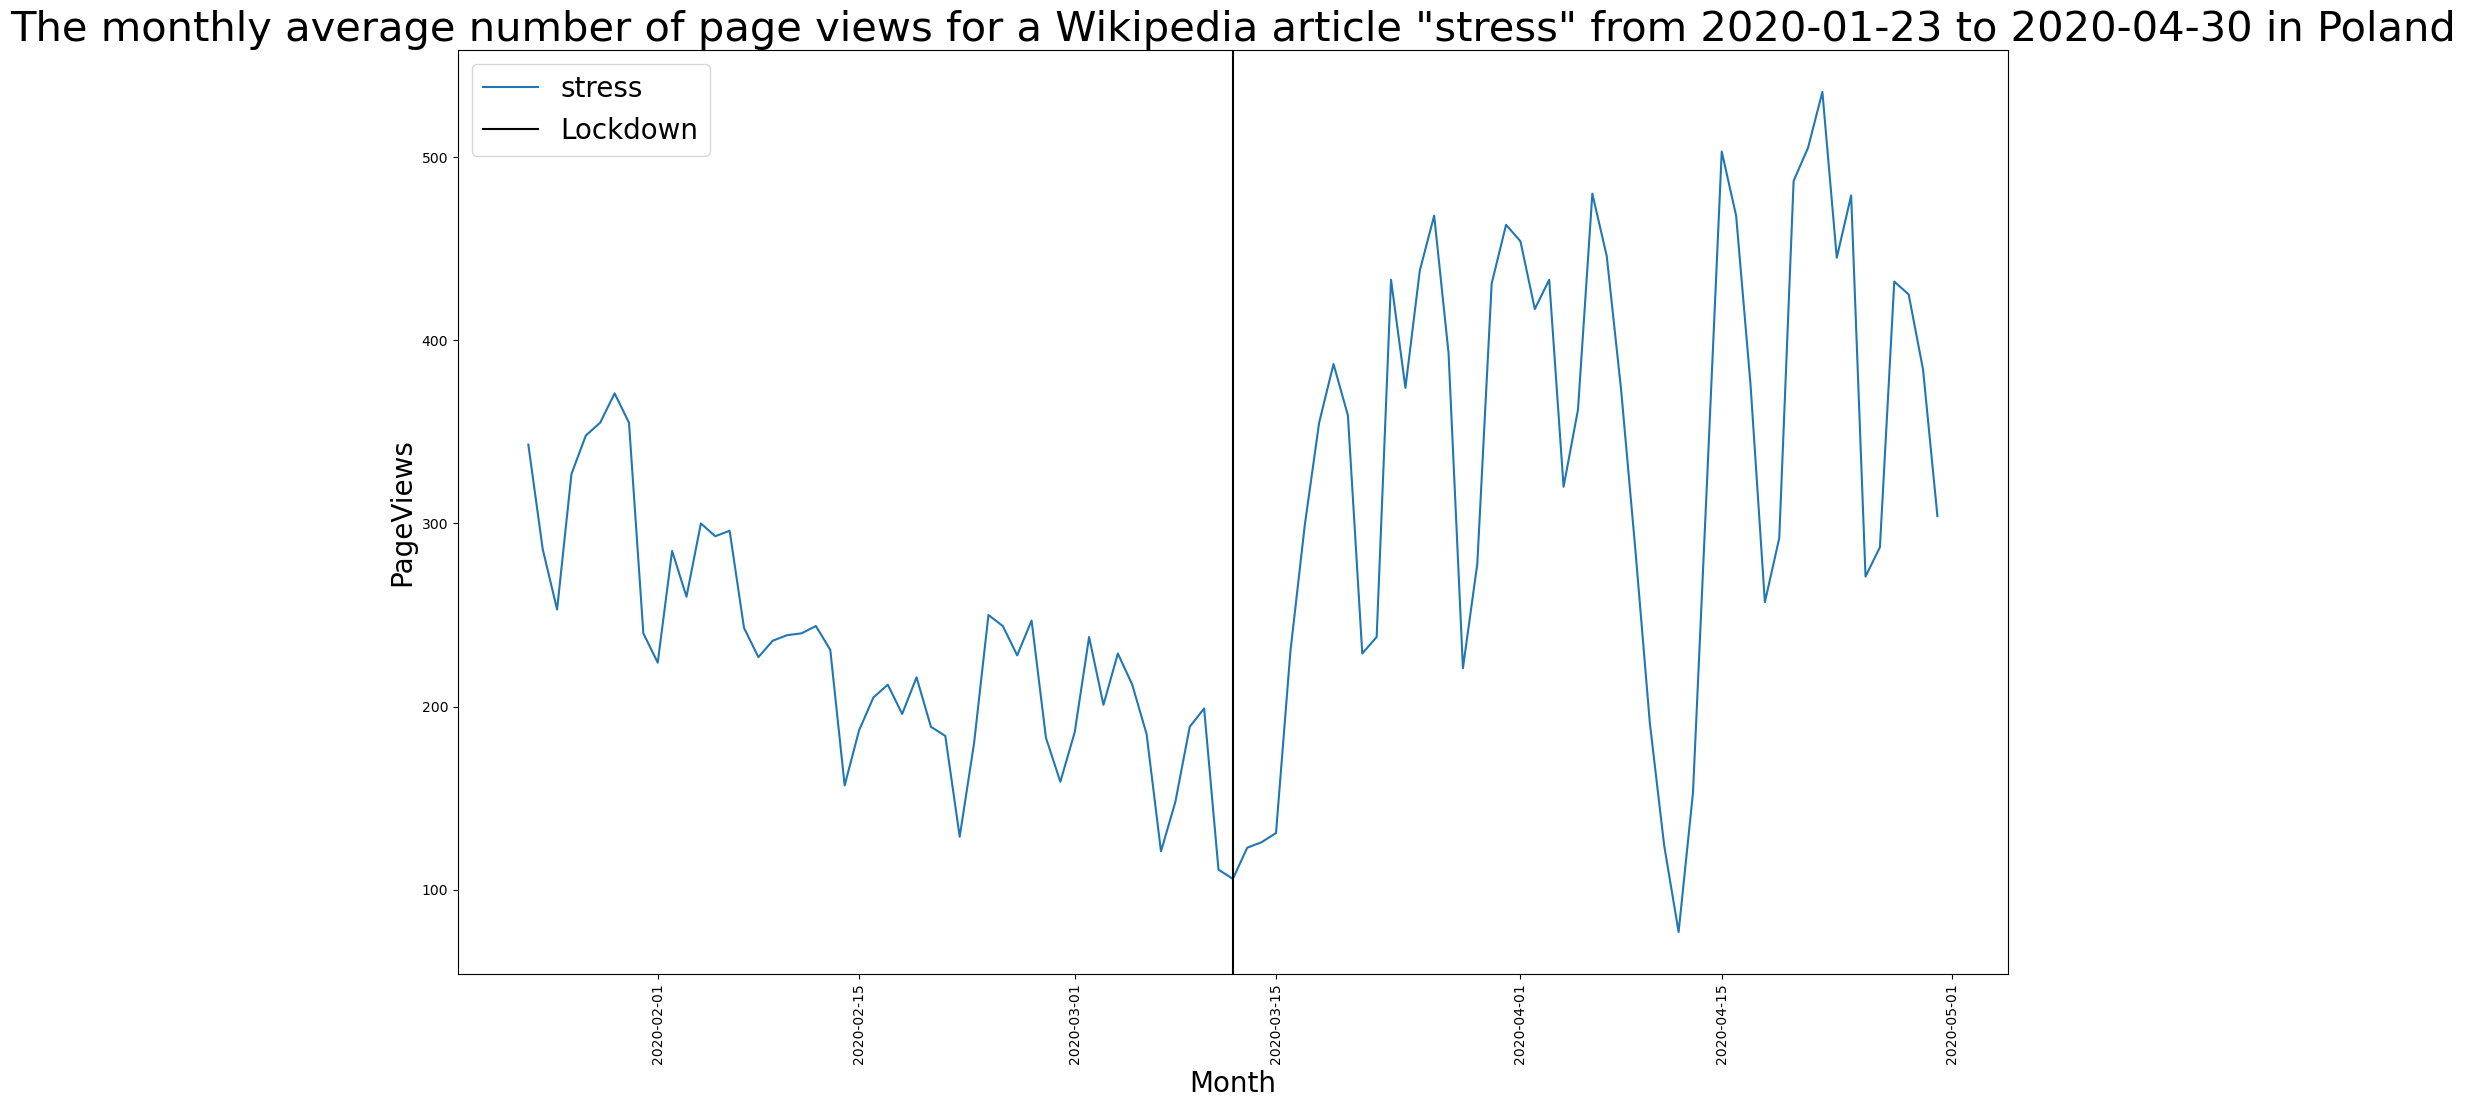

In [33]:
plotDisorderPageViews('pl', 'stress', dates['pl'][3], dates['pl'][5])

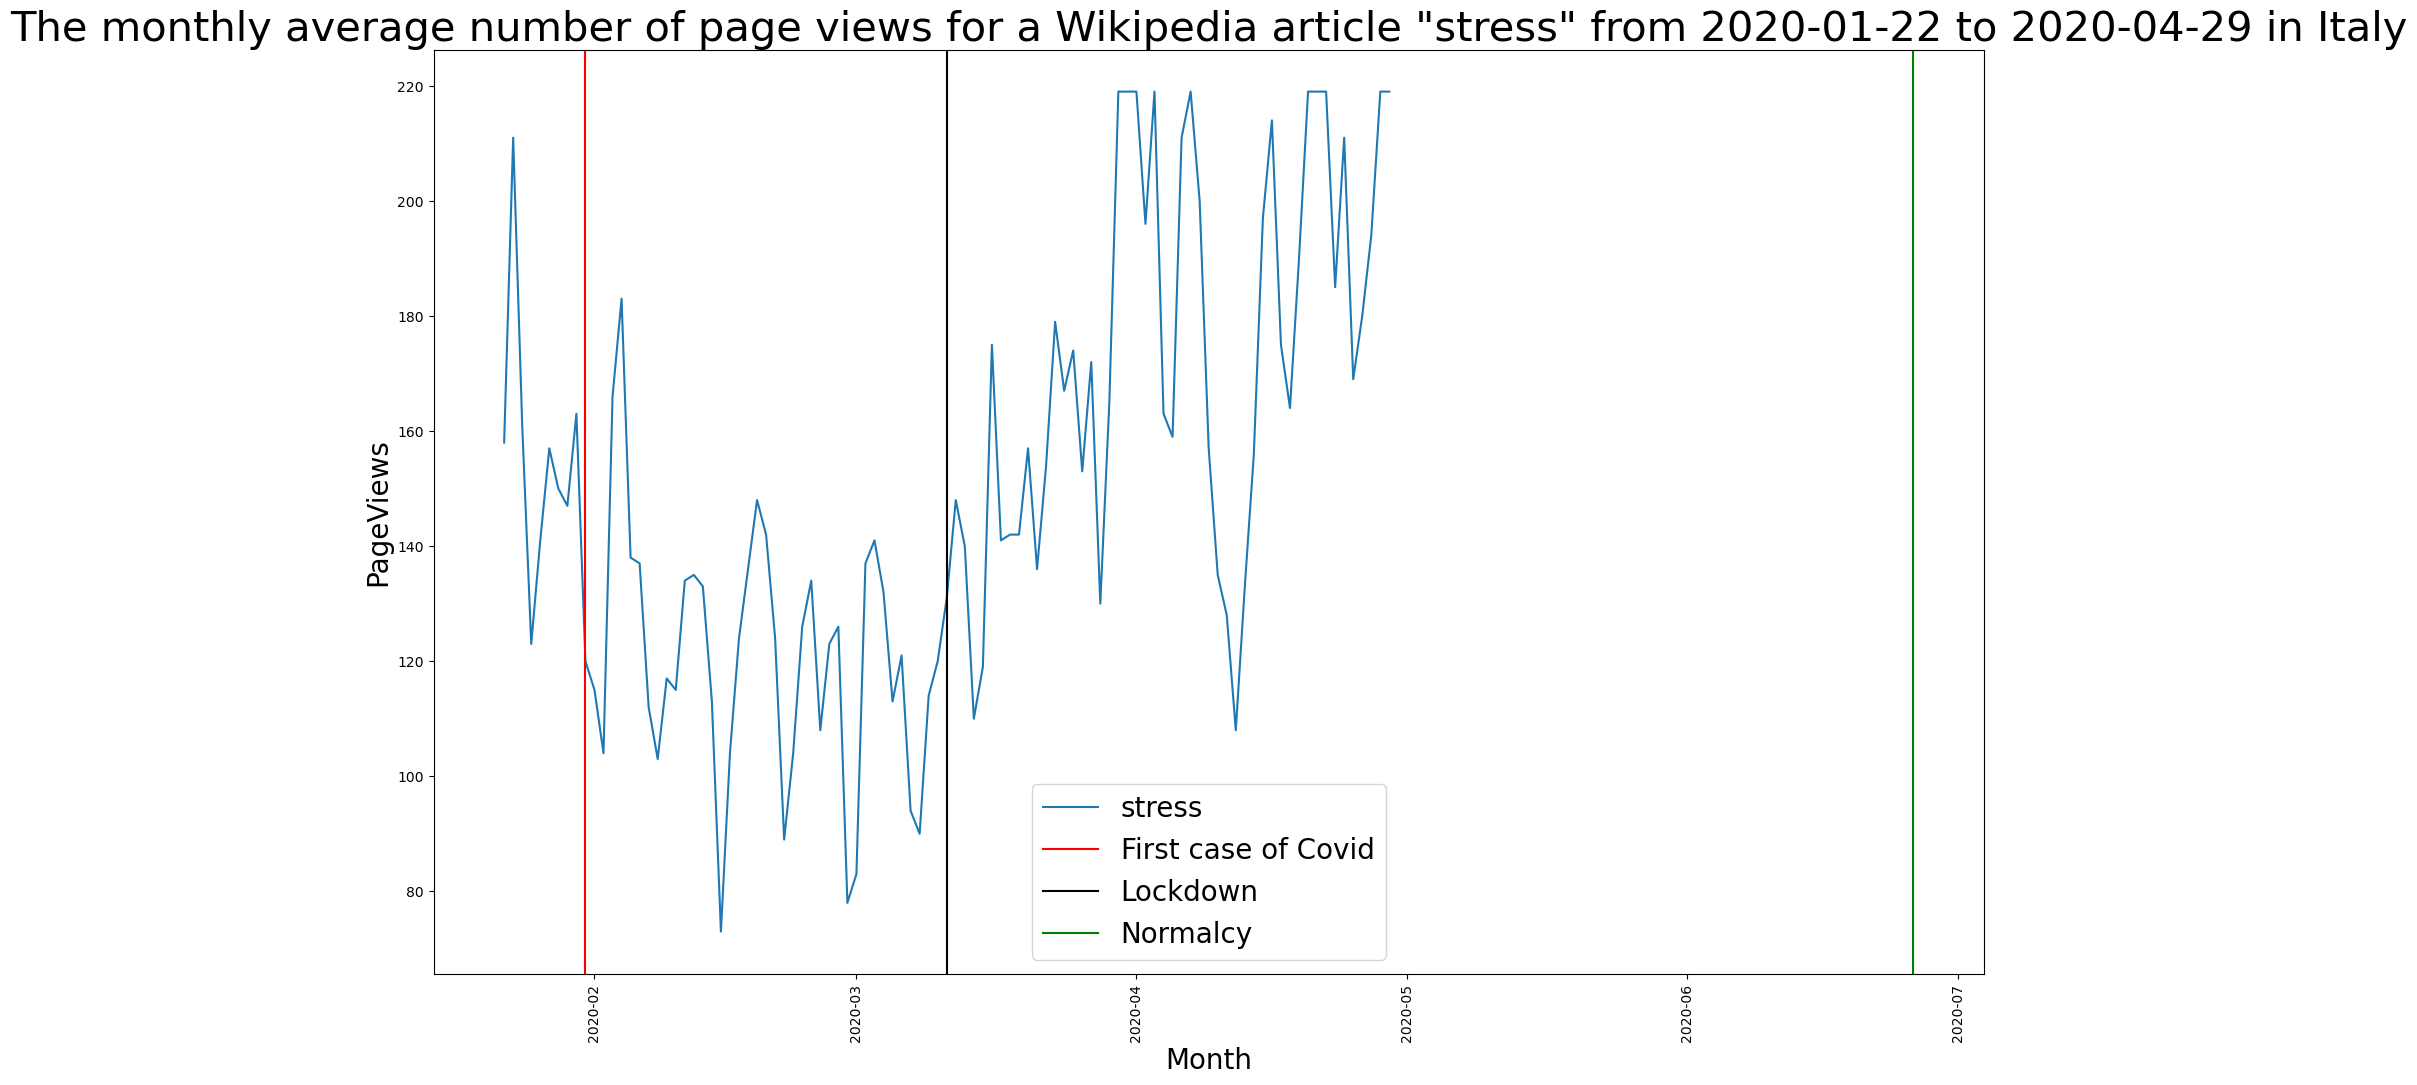

In [34]:
plotDisorderPageViews('it', 'stress', dates['it'][3], dates['it'][5])

Here also the effect is seen visually.

# Q2: Does mobility affect mental health interests on Wikipedia?

### Linear Regression

In [46]:
#To store results from regression
it_reg_res = []
nl_reg_res = []
sv_reg_res = []
pl_reg_res = []

In [47]:
def regression(disease, lang, df):
    #Note removed C(month)
    #Bad idea to have highly correlated features in regression, here we judged wise to take average of driving walking (and transit)
    if lang == 'pl': #No transit data for poland
        mod = smf.ols(formula= disease + ' ~ driving + walking + retail + grocery + parks + stations + workplaces + residential + C(first_case) + C(first_death) + C(lockdown) + C(is_weekend)', data=df)
    else:
        mod = smf.ols(formula= disease + ' ~ driving + transit + walking + retail + grocery + parks + stations + workplaces + residential + C(first_case) + C(first_death) + C(lockdown) + C(is_weekend)', data=df)
    np.random.seed(2)
    res = mod.fit()
    if(lang == 'nl'):
        nl_reg_res.append(res)
    elif(lang == 'sv'):
        sv_reg_res.append(res)
    elif(lang == 'pl'):
        pl_reg_res.append(res)
    elif(lang == 'it'):
        it_reg_res.append(res)
    
    print('\n Regression for ' + disease + ' in ' + region[lang] + '\n')
    print(res.summary())

def standardize_non_catergorical_features(df, lang):
    df_categorical = df[["first_case", "first_death", "lockdown", "month", "is_weekend"]]
    df_targets = df[["anxiety",  "depression",  "insomnia", "loneliness", "stress" ]] #dont standardize the targets
    if(lang == 'pl'):
        df_non_categorical = df[["driving", "walking", "retail", "grocery", "parks", "stations", "workplaces", "residential"]]
    else: 
        df_non_categorical = df[["driving", "walking", "retail", "grocery", "parks", "stations", "transit", "workplaces", "residential"]]
        
    df_non_categorical_standardized =  (df_non_categorical - df_non_categorical.mean())/df_non_categorical.std() #standardization
    df_standardized_features = df_non_categorical_standardized.join(df_categorical).join(df_targets)
    #print(df_standardized.head(5))
    return df_standardized_features

def loop(langs, diseases):
    #each array with have 5 elements, one for each disease
    #the order of the diseases will be :  'anxiety', 'depression', 'insomnia', 'loneliness', 'stress'

    for lang in langs:
        pageviews = get_pageviews_data(lang)
        apple = get_apple_data(lang)
        google = get_google_data(lang)
        df = merge_datasets(pageviews, apple, google)
        #print(df);
        df_standardized  = standardize_non_catergorical_features(df, lang) 
        for disease in diseases:
            regression(disease, lang, df_standardized)

In [49]:
loop(LANGUAGES, diseases_names['en'])

ParserError: Unknown string format: alternative_name

# Q3: What are the differences in effects of lockdowns on mobility in different countries and how do these effects translate to the mental health status of their citizens?

In this part, we will try to answer to answer this question. In order to do that, we will look at the evolution of mental health perception (Stress and loneliness) accross time using COVIDiSTRESS dataset. Then we will look at the pageviews concerning these specific topics during the same period of time as COVIDiSTRESS survey. We will then continue by doing the same with the mobility, using google dataset of mobility. And finally we will look, if there is a correlation between thes 3 effects, if there is one. As explained, in the README, we will conduct this analysis on 4 countries in particular: Italy, the Netherlands, Sweden, and Poland, as they all had different measured applied.

## Covidistress process

In [35]:
#Get the Covidistress data
df_covidistress = pd.read_csv(DATA_PATH + "df_covidistress_clean.csv", low_memory=False)

We can look again at our median distribution for Stress and loneliness perception accross our 4 countries of interest

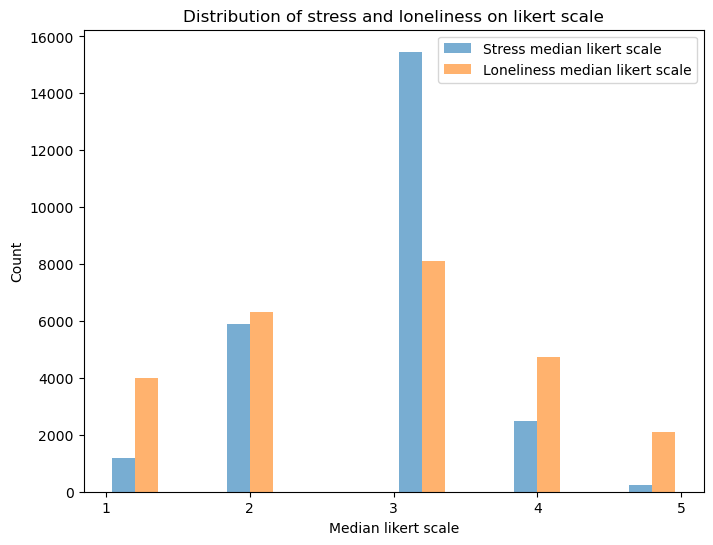

In [36]:
#plot compare distribution of stress and loneliness

plt.figure(figsize=(8,6))
plt.hist([df_covidistress['median_stress'],df_covidistress['median_loneliness']], alpha=0.6, label=['Stress median likert scale', 'Loneliness median likert scale'])
plt.xticks([1,2,3,4,5])
plt.xlabel('Median likert scale')
plt.ylabel('Count')
plt.title('Distribution of stress and loneliness on likert scale')
plt.legend(loc='upper right')
#export to png
plt.savefig(FIGURE_PATH + '\\' +'covidistress_hist_stress_loneliness.png')

plt.show()



It seems the overall disribution is quite normal

Let's look more in details in each countries

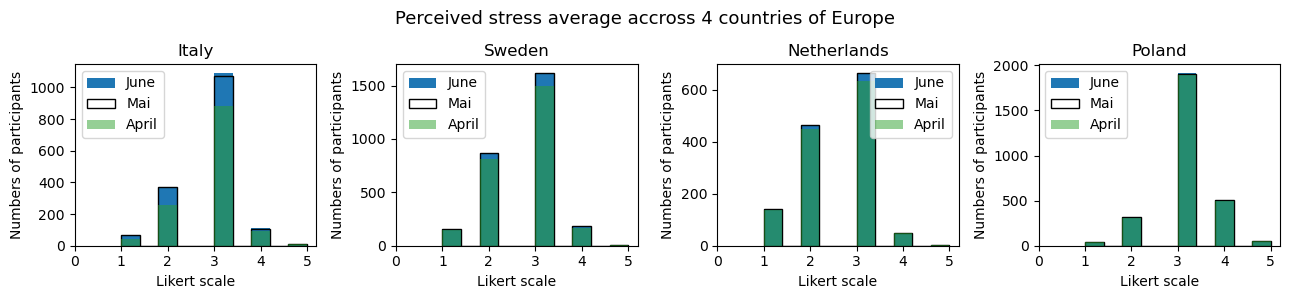

In [37]:
#list of months to choose data set and countries of interests
MONTHS = ['June', 'Mai', 'April']
COUNTRIES_INTEREST = ['Italy', 'Sweden', 'Netherlands', 'Poland']

#plot histogramme of the stress median by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()

for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df by countries of interest and month
    df_hist_june = df_covidistress.loc[(df_covidistress['period'] == 'June') & (df_covidistress['Country'] == country)]
    df_hist_mai = df_covidistress.loc[(df_covidistress['period'] == 'Mai') & (df_covidistress['Country'] == country)]
    df_hist_april = df_covidistress.loc[(df_covidistress['period'] == 'April') & (df_covidistress['Country'] == country)]
    axe.hist(df_hist_june['median_stress'][:])
    axe.hist(df_hist_mai['median_stress'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['median_stress'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived stress average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)
#export to png
plt.savefig(FIGURE_PATH + '\\' +'covidistress_hist_stress_by_country.png')
plt.show()



With a closer look at the median perception of stress in each country, the normalize distribution seems to shift a bit on the left except for Poland 

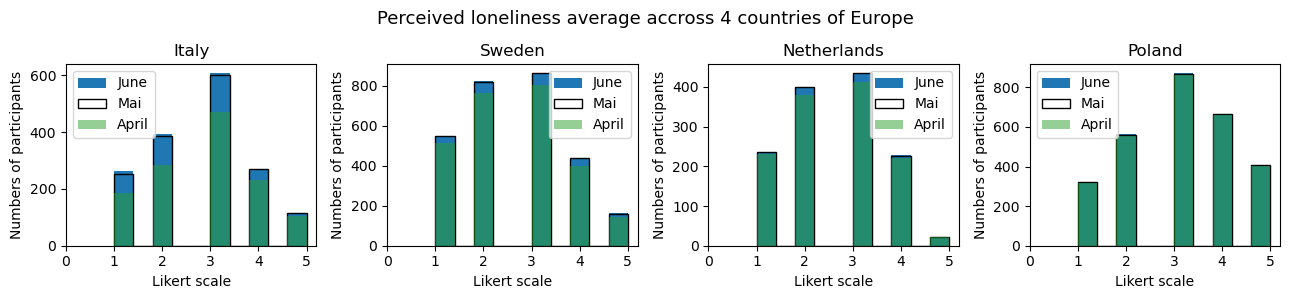

In [38]:
#plot histogramme of the loneliness median by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()

for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df by countries of interest and month
    df_hist_june = df_covidistress.loc[(df_covidistress['period'] == 'June') & (df_covidistress['Country'] == country)]
    df_hist_mai = df_covidistress.loc[(df_covidistress['period'] == 'Mai') & (df_covidistress['Country'] == country)]
    df_hist_april = df_covidistress.loc[(df_covidistress['period'] == 'April') & (df_covidistress['Country'] == country)]
    axe.hist(df_hist_june['median_loneliness'][:])
    axe.hist(df_hist_mai['median_loneliness'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['median_loneliness'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived loneliness average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)
#export to png
plt.savefig(FIGURE_PATH + '\\' +'covidistress_hist_loneliness_by_country.png')
plt.show()



The same goes for loneliness median perception

At first glance, there doesn't seem to have a difference in perceptions between most period in each country. However we have slightly different distribution between country. We will now look at it more in details doing statistical multicomparison test in order to see if there is a difference in time and country.

### Anova testing followed by Conover's Post hoc test.

We do an ANOVA test to look for difference in period and countries and post hoc Conover to see which particular period or country is different if we find statistical results.

In [39]:
alpha_sidak_period = 1 - (1 - 0.05) ** (1 / 3) # Bonferroni correction
print('Sidak correction for period is: ', alpha_sidak_period)
alpha_sidak_country = 1 - (1 - 0.05) ** (1 / 4) # Bonferroni correction
print('Sidak correction for country is: ', alpha_sidak_country)

Sidak correction for period is:  0.016952427508441503
Sidak correction for country is:  0.012741455098566168


#### Stress perception analysis

In [40]:
#anova test for stress perception
df_covidistress.anova(dv='median_stress', between=['period', 'Country'])

,Source,SS,DF,MS,F,p-unc,np2
0,period,0.225377,2.0,0.112688,0.245275,0.782491,0.000019
1,Country,1238.612678,3.0,412.870893,898.646135,0.000000,0.096594
2,period * Country,2.286001,6.0,0.381000,0.829277,0.546951,0.000197
3,Residual,11584.233533,25214.0,0.459437,NaN,NaN,NaN


As we can see here only Country shows significant effect.
Indeed, as seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.

We can now look at the Tukey HSD and conover post hoc test to see which countries differs from the others

In [41]:
sp.posthoc_conover(df_covidistress, val_col='median_stress', group_col='Country', p_adjust='sidak')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,4.113532e-96,6.111039e-121,1.133456e-27
Netherlands,4.113532e-96,1.000000e+00,0.000000e+00,5.162962e-38
Poland,6.111039e-121,0.000000e+00,1.000000e+00,0.000000e+00
Sweden,1.133456e-27,5.162962e-38,0.000000e+00,1.000000e+00


We can see here that, all countries are significantly different in terms of stress perception

#### Loneliness perception analysis

In [42]:
df_covidistress.anova(dv='median_loneliness', between=['period', 'Country'])

,Source,SS,DF,MS,F,p-unc,np2
0,period,0.598883,2.0,0.299441,0.230234,7.943490e-01,0.000018
1,Country,1383.262324,3.0,461.087441,354.520932,1.567319e-225,0.040474
2,period * Country,5.315165,6.0,0.885861,0.681121,6.649423e-01,0.000162
3,Residual,32793.151819,25214.0,1.300593,NaN,NaN,NaN


As seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.
Again only country shows sgnificant effect.

Let's check also which countries differ using the posth hoc tests

In [43]:
sp.posthoc_conover(df_covidistress, val_col='median_loneliness', group_col='Country', p_adjust='holm')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,6.592096e-19,3.411188e-48,6.258056e-20
Netherlands,6.592096e-19,1.000000e+00,5.129051e-126,2.042965e-01
Poland,3.411188e-48,5.129051e-126,1.000000e+00,1.039639e-175
Sweden,6.258056e-20,2.042965e-01,1.039639e-175,1.000000e+00


We can see that they all differ between each other except Sweden and Netherlands in terms of perceived loneliness

Unfortunately, we don't find any significant change in time for the perceived mental issues from Covidistress. However, we notice some differences between countries, this may be due to the mobility decisions in each country, which we will explore later on.

## Wiki pageviews process
We will now look at the evolution of pageviews about our 2 mental health of interest accross the 4 countries of interest

In [44]:
#function from q2

def is_affected(lang, effect, day):
    x = interventions_data[effect].loc[lang]
    if x == pd.NaT:
        return 0
    if day >= x and day < x + timedelta(days=EFFECT_DURATION):
        return 1
    return 0

def is_lockdown(lang, day):
    start = interventions_data['Lockdown'].loc[lang]
    end = interventions_data['Normalcy'].loc[lang]
    if start == pd.NaT or end == pd.NaT:
        return 0
    if day >= start and day < end:
        return 1
    return 0

def get_pageviews_data(lang):
    df = pageviews_data[lang].copy()
    df.rename(columns = dict(zip(diseases_names[lang], diseases_names['en'])), inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day_of_the_week'] = df['Date'].apply(lambda x: x.strftime("%A"))
    df['first_case'] = df['Date'].apply(lambda x: is_affected(lang, '1st case', x))
    df['first_death'] = df['Date'].apply(lambda x: is_affected(lang, '1st death', x))
    df['lockdown'] = df['Date'].apply(lambda x: is_lockdown(lang, x))
    df['month'] = df['Date'].apply(lambda date: date.month) #add month

    df.set_index('Date', inplace=True)
    df = df[diseases_names['en'] + ['Day_of_the_week', 'first_case', 'first_death', 'lockdown', 'month']]
    return df

def get_apple_data(lang):
    df = apple_mobility_data.loc[apple_mobility_data['region'] == region[lang]]
    if lang == 'pl': #no transit data for poland
        df.index = ['driving', 'walking']
    else:
        df.index = ['driving', 'transit', 'walking']
    df = df.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
    df = df.T
    df.index = pd.to_datetime(df.index)
    return df

def get_google_data(lang):
    df = google_mobility_data[google_mobility_data['country_region'] == region[lang]]
    df = df[df['sub_region_1'].isna()] #keep only rows with country level data (for italy only using sub_region_1 is enough)
    df = df.dropna(axis=1, how='all') #keep only rows without NaN values(should drop all "sub_region"s)
    df = df.interpolate() #replace NaN values with average of bfill and ffill (No NaN values in this filtered dataframe but not necessarily the case)
    df.set_index(pd.DatetimeIndex(df['date']), inplace = True)
    del df['date']
    df = df.drop_duplicates()
    df.rename(columns = {'retail_and_recreation_percent_change_from_baseline':'retail',
                        'grocery_and_pharmacy_percent_change_from_baseline':'grocery',
                        'parks_percent_change_from_baseline':'parks',
                        'transit_stations_percent_change_from_baseline':'stations',
                        'workplaces_percent_change_from_baseline':'workplaces',
                        'residential_percent_change_from_baseline':'residential'},
                        inplace = True)
    return df

def merge_datasets(pageviews, apple, google):
    df = pd.merge(pageviews, apple, left_index=True, right_index=True)
    df = pd.merge(df, google, left_index=True, right_index=True)
    return df

def get_dfs(lang, diseases):
    pageviews = get_pageviews_data(lang)
    apple = get_apple_data(lang)
    google = get_google_data(lang)
    df = merge_datasets(pageviews, apple, google)
    return df
        


In [45]:
#get dataframes for each country
df_pv_italy_all = get_dfs('it', diseases_names['en'])
df_pv_netherlands_all = get_dfs('nl', diseases_names['en'])
df_pv_sweden_all = get_dfs('sv', diseases_names['en'])
df_pv_poland_all = get_dfs('pl', diseases_names['en'])

START_CD = pd.to_datetime('2020-03-30')
END_CD = pd.to_datetime('2020-06-17')
#get points from START_CD to END_CD in each country dataframe
df_pv_italy = df_pv_italy_all.loc[START_CD:END_CD]
df_pv_netherlands = df_pv_netherlands_all.loc[START_CD:END_CD]
df_pv_sweden = df_pv_sweden_all.loc[START_CD:END_CD]
df_pv_poland = df_pv_poland_all.loc[START_CD:END_CD]


ParserError: Unknown string format: alternative_name